# Data Loading and Preprocessing

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os

In [3]:
path = Path('Database')
path

PosixPath('Database')

In [4]:
image_count = len(list(path.glob('*/*.jpg')))
print(image_count)

1


In [5]:
batch_size = 32
img_height = 224
img_width = 224

In [6]:
# Taking tensorflow dataset of locations of images and shuffling them

list_ds = tf.data.Dataset.list_files(str(path/'*/*'), shuffle=True)

2023-07-30 16:35:53.261414: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-07-30 16:35:53.261526: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-07-30 16:35:53.261551: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-07-30 16:35:53.261753: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-30 16:35:53.261848: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# Displaying first five addresses

for f in list_ds.take(5):
    print(f.numpy())

b'Database/Pepper__bell___Bacterial_spot/a9c4f5b6-dd12-492d-bdd3-b2a593916add___JR_B.Spot 8871.JPG'
b'Database/Pepper__bell___Bacterial_spot/376e68b6-818c-4ed5-97d2-ec9b0ac55bff___NREC_B.Spot 9102.JPG'
b'Database/Pepper__bell___healthy/c874080b-be91-4c77-967f-092f91884297___JR_HL 7919.JPG'
b'Database/Pepper__bell___healthy/ada9a8bc-c0a4-4adb-bedd-a6c6a5138ff0___JR_HL 5900.JPG'
b'Database/Pepper__bell___Bacterial_spot/0719e8e8-c1ae-4d5a-b29c-dbadc36d13f3___NREC_B.Spot 1947.JPG'


In [8]:
# Printing labels present in dataset

class_names = np.array(sorted([item.name for item in path.glob('*') if item.name != "LICENSE.txt"]))
num_classes = len(class_names)
print(class_names)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy']


In [9]:
# Defining training, validation and testing datasets


train_ds = list_ds.skip(600)
val_ds = list_ds.take(300)
test_ds = list_ds.take(300)

In [10]:
len(list(train_ds))

1875

In [11]:
# Below function takes path as an input and returns label

def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

In [12]:
# This function turns images into 3D tensor and resizes it

def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [13]:
# Below function gets images from path input and uses above 2 functions to convert into 3D tensors and assigns labels

def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

In [15]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [16]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  0


In [17]:
# Caching, batching and prefetching datasets

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

# Displaying Data

2023-07-30 16:36:00.778022: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


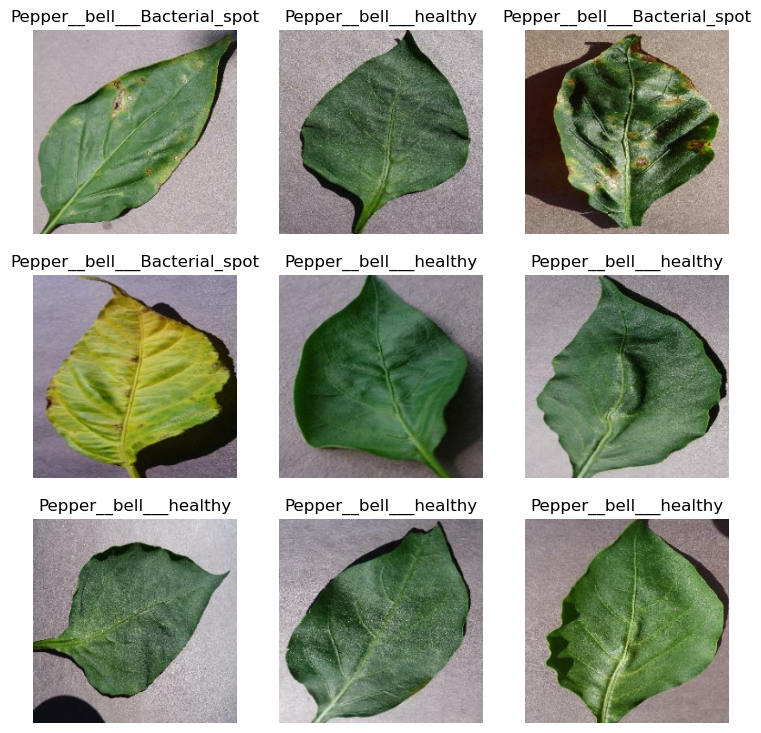

In [18]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(9,9))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

# Training model with random hyperparameters

In [19]:
# Describing model

model = tf.keras.Sequential([
                    tf.keras.layers.Rescaling(1./255),
                    tf.keras.layers.RandomFlip(mode = 'horizontal_and_vertical', seed=None),
                    tf.keras.layers.RandomRotation((-0.5,0.5),fill_mode='reflect',interpolation='bilinear',seed=None,fill_value=0.0),
                    tf.keras.layers.Conv2D(32, 3, activation='relu'),
                    tf.keras.layers.MaxPooling2D(),
                    tf.keras.layers.Conv2D(32, 3, activation='relu'),
                    tf.keras.layers.MaxPooling2D(),
                    tf.keras.layers.Conv2D(32, 3, activation='relu'),
                    tf.keras.layers.MaxPooling2D(),
                    tf.keras.layers.Conv2D(32, 3, activation='relu'),
                    tf.keras.layers.MaxPooling2D(),
                    tf.keras.layers.Conv2D(32, 3, activation='relu'),
                    tf.keras.layers.MaxPooling2D(),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(80, activation='relu'),
                    tf.keras.layers.Dense(num_classes)])

In [20]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
 model.fit(train_ds,
            validation_data=val_ds,
            epochs=3)

Epoch 1/3


2023-07-30 16:36:17.470455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-30 16:36:17.671436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:17.671528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/59 [=>............................] - ETA: 2s - loss: 13070.9707 - accuracy: 0.3984

2023-07-30 16:36:19.875362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:19.877674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:19.931227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:19.931502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:19.979412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:19.980551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 9/59 [===>..........................] - ETA: 2s - loss: 288765.6562 - accuracy: 0.4444

2023-07-30 16:36:20.088704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:20.089073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:20.133928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:20.134198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:20.179076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:20.179843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

13/59 [=====>........................] - ETA: 2s - loss: 200135.3281 - accuracy: 0.4183

2023-07-30 16:36:20.316147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:20.317591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:20.361000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:20.361011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:20.407099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:20.407277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/59 [========>.....................] - ETA: 1s - loss: 136937.9375 - accuracy: 0.4243

2023-07-30 16:36:20.543333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:20.543739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:20.587910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:20.587992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:20.633556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:20.633602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

23/59 [==========>...................] - ETA: 1s - loss: 113122.8359 - accuracy: 0.4226

2023-07-30 16:36:20.768365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:20.768392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:20.815794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:20.815794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:20.860184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:20.860196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

29/59 [=============>................] - ETA: 1s - loss: 89718.4062 - accuracy: 0.4450

2023-07-30 16:36:20.996844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:20.996844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.043087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.043087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.087571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.087580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

33/59 [===============>..............] - ETA: 1s - loss: 78843.6250 - accuracy: 0.4716

2023-07-30 16:36:21.221703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.221766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.267266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.267791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.312245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.312343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

39/59 [==================>...........] - ETA: 0s - loss: 66713.9844 - accuracy: 0.4984

2023-07-30 16:36:21.447709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.447718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.493020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.493044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.538655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.538654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/59 [====================>.........] - ETA: 0s - loss: 60508.1055 - accuracy: 0.5051

2023-07-30 16:36:21.672736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.672931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.720810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.720947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.767729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.767734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

49/59 [=======================>......] - ETA: 0s - loss: 53099.0508 - accuracy: 0.4949

2023-07-30 16:36:21.904475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.904604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.951287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.951331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.997527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:21.997669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

53/59 [=========================>....] - ETA: 0s - loss: 49091.6367 - accuracy: 0.4917

2023-07-30 16:36:22.133929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:22.135160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:22.180124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:22.180131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:22.225695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:22.225704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

57/59 [===========================>..] - ETA: 0s - loss: 45646.6641 - accuracy: 0.4863

2023-07-30 16:36:22.360595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:22.360729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:22.405253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:22.406223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:22.449710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:22.450140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - ETA: 0s - loss: 44405.0938 - accuracy: 0.4875

2023-07-30 16:36:23.198076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - 7s 63ms/step - loss: 44405.0938 - accuracy: 0.4875 - val_loss: 0.6677 - val_accuracy: 0.6167
Epoch 2/3
 3/59 [>.............................] - ETA: 2s - loss: 0.6793 - accuracy: 0.6042

2023-07-30 16:36:23.527417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:23.527634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:23.581973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:23.582179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:23.625608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:23.627201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 8/59 [===>..........................] - ETA: 2s - loss: 0.6950 - accuracy: 0.6133

2023-07-30 16:36:23.742676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:23.742718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:23.790647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:23.791538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:23.835464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:23.835468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

12/59 [=====>........................] - ETA: 2s - loss: 0.6795 - accuracy: 0.6302

2023-07-30 16:36:23.973392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:23.973528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.017202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.017411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.061546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.061609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

18/59 [========>.....................] - ETA: 1s - loss: 0.6845 - accuracy: 0.6128

2023-07-30 16:36:24.199374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.199405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.246244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.246576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.291618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.291828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

22/59 [==========>...................] - ETA: 1s - loss: 0.6865 - accuracy: 0.5980

2023-07-30 16:36:24.424181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.424186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.473100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.473104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.517192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.517373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

28/59 [=============>................] - ETA: 1s - loss: 0.6885 - accuracy: 0.5547

2023-07-30 16:36:24.656546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.656725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.700067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.700404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.747151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.747151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

32/59 [===============>..............] - ETA: 1s - loss: 0.6869 - accuracy: 0.5713

2023-07-30 16:36:24.884798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.884842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.934537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.934998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.980612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:24.980947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

38/59 [==================>...........] - ETA: 0s - loss: 0.6843 - accuracy: 0.5765

2023-07-30 16:36:25.111818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:25.112292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:25.161294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:25.161310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:25.207575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:25.207668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

42/59 [====================>.........] - ETA: 0s - loss: 0.6814 - accuracy: 0.5833

2023-07-30 16:36:25.350336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:25.350376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:25.398832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:25.399299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:25.446444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:25.446873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

48/59 [=======================>......] - ETA: 0s - loss: 0.6862 - accuracy: 0.5788

2023-07-30 16:36:25.587743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:25.587794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:25.637282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:25.637379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:25.680973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:25.681011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

52/59 [=========================>....] - ETA: 0s - loss: 0.6849 - accuracy: 0.5811

2023-07-30 16:36:25.817683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:25.818173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:25.863152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:25.863191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:25.906009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:25.906703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

58/59 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.5846

2023-07-30 16:36:26.043630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:26.044063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:26.092497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:26.093147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:26.137812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:26.137907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 48ms/step - loss: 0.6848 - accuracy: 0.5835 - val_loss: 0.6697 - val_accuracy: 0.6167
Epoch 3/3
 3/59 [>.............................] - ETA: 2s - loss: 0.6719 - accuracy: 0.6042

2023-07-30 16:36:26.360253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:26.360578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:26.410733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:26.410879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:26.459594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:26.459917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 9/59 [===>..........................] - ETA: 2s - loss: 0.6693 - accuracy: 0.6181

2023-07-30 16:36:26.596488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:26.596643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:26.639640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:26.639909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:26.683994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:26.684036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

13/59 [=====>........................] - ETA: 2s - loss: 0.6645 - accuracy: 0.6250

2023-07-30 16:36:26.822105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:26.822129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:26.867845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:26.868007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:26.915274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:26.915845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/59 [========>.....................] - ETA: 1s - loss: 0.6741 - accuracy: 0.6053

2023-07-30 16:36:27.050199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:27.050362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:27.094503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:27.095363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:27.138227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:27.138234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

23/59 [==========>...................] - ETA: 1s - loss: 0.6760 - accuracy: 0.6019

2023-07-30 16:36:27.272166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:27.272327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:27.317233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:27.317257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:27.360061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:27.361013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

29/59 [=============>................] - ETA: 1s - loss: 0.6793 - accuracy: 0.5873

2023-07-30 16:36:27.494525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:27.494724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:27.538445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:27.538724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:27.588978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:27.589294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

33/59 [===============>..............] - ETA: 1s - loss: 0.6791 - accuracy: 0.5966

2023-07-30 16:36:27.722530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:27.722643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:27.767859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:27.767865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:27.812364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:27.812432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

38/59 [==================>...........] - ETA: 0s - loss: 0.6773 - accuracy: 0.5995

2023-07-30 16:36:27.949204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:27.949232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:27.993201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:27.993204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:28.037674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:28.037680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

44/59 [=====================>........] - ETA: 0s - loss: 0.6781 - accuracy: 0.6009

2023-07-30 16:36:28.182237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:28.183285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:28.226515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:28.226671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:28.270673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:28.270957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

48/59 [=======================>......] - ETA: 0s - loss: 0.6804 - accuracy: 0.5970

2023-07-30 16:36:28.404605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:28.404999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:28.450313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:28.450310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:28.494436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:28.494465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

54/59 [==========================>...] - ETA: 0s - loss: 0.6800 - accuracy: 0.5966

2023-07-30 16:36:28.627264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:28.627972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:28.671767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:28.671823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:28.721056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:28.721201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

58/59 [============================>.] - ETA: 0s - loss: 0.6798 - accuracy: 0.5997

2023-07-30 16:36:28.864903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:28.864922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:28.908392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:28.909003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:28.954527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:36:28.954712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 47ms/step - loss: 0.6802 - accuracy: 0.5984 - val_loss: 0.6674 - val_accuracy: 0.6167


In [23]:
print("Accuracy before hyperparameter tuning =",model.history.history['val_accuracy'][2])

Accuracy before hyperparameter tuning = 0.6166666746139526


# Hyperparameter Tuning

In [27]:
# Below function runs 3 loops sperately of each hyperparameter and is storing accuracy at each step for each epoch.
# Since it is taking so much time for training we took step of 64 instead of 32.
# We are running for 10 epochs to ensure complete training of the model
# At each step we are defining model so it resets the parameters learned in previous step

def hyperparameter_tuning(num_classes,epochs):
    num_dense = [32,64,128]
    learning_rate = [0.01,0.001]
    optimizer = [tf.keras.optimizers.Adam, tf.keras.optimizers.experimental.SGD]
    accuracy=[]
    hyperparameters = []
    for i in num_dense:
        for j in learning_rate:
            for k in optimizer:
                model = tf.keras.Sequential([
                    tf.keras.layers.Rescaling(1./255),
                    tf.keras.layers.RandomFlip(mode = 'horizontal_and_vertical', seed=None),
                    tf.keras.layers.RandomRotation((-0.5,0.5),fill_mode='reflect',interpolation='bilinear',seed=None,fill_value=0.0),
                    tf.keras.layers.Conv2D(32, 3, activation='relu'),
                    tf.keras.layers.MaxPooling2D(),
                    tf.keras.layers.Conv2D(32, 3, activation='relu'),
                    tf.keras.layers.MaxPooling2D(),
                    tf.keras.layers.Conv2D(32, 3, activation='relu'),
                    tf.keras.layers.MaxPooling2D(),
                    tf.keras.layers.Conv2D(32, 3, activation='relu'),
                    tf.keras.layers.MaxPooling2D(),
                    tf.keras.layers.Conv2D(32, 3, activation='relu'),
                    tf.keras.layers.MaxPooling2D(),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(i, activation='relu'),
                    tf.keras.layers.Dense(num_classes)])
                
                model.compile(
                    optimizer = k(learning_rate=j),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])
                
                model.fit(
                    train_ds,
                    validation_data=val_ds,
                    epochs=epochs)
                
                history = model.history.history
                accuracy.append(history['val_accuracy'])
                hyperparameters.append([i,j,k])
                
    return accuracy, hyperparameters

In [28]:
accuracy, hyperparameters = hyperparameter_tuning(num_classes,3)

Epoch 1/3


2023-07-30 16:37:37.018259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-30 16:37:37.113748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:37.114708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/59 [=>............................] - ETA: 2s - loss: 0.9440 - accuracy: 0.4297

2023-07-30 16:37:37.301740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:37.302213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:37.352897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:37.352907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:37.399548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:37.400354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 9/59 [===>..........................] - ETA: 2s - loss: 0.8074 - accuracy: 0.4340

2023-07-30 16:37:37.536505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:37.537010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:37.587392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:37.587473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:37.632153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:37.632521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

14/59 [======>.......................] - ETA: 2s - loss: 0.7653 - accuracy: 0.5022

2023-07-30 16:37:37.771591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:37.772819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:37.820169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:37.820753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:37.866558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:37.866920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/59 [========>.....................] - ETA: 1s - loss: 0.7452 - accuracy: 0.5181

2023-07-30 16:37:37.985394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:37.985929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:38.035562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:38.035974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:38.086082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:38.086367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

24/59 [===========>..................] - ETA: 1s - loss: 0.7332 - accuracy: 0.5326

2023-07-30 16:37:38.223604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:38.224631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:38.268634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:38.269339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:38.318394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:38.319064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

28/59 [=============>................] - ETA: 1s - loss: 0.7280 - accuracy: 0.5268

2023-07-30 16:37:38.468350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:38.469254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:38.515688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:38.516253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:38.559987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:38.560054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

34/59 [================>.............] - ETA: 1s - loss: 0.7181 - accuracy: 0.5496

2023-07-30 16:37:38.697742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:38.698509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:38.741975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:38.742185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:38.793251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:38.793381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

38/59 [==================>...........] - ETA: 1s - loss: 0.7132 - accuracy: 0.5559

2023-07-30 16:37:38.932465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:38.932651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:38.977583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:38.977854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:39.021416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:39.021707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

44/59 [=====================>........] - ETA: 0s - loss: 0.7080 - accuracy: 0.5632

2023-07-30 16:37:39.152696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:39.153193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:39.198216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:39.198408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:39.241979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:39.242111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

48/59 [=======================>......] - ETA: 0s - loss: 0.7074 - accuracy: 0.5625

2023-07-30 16:37:39.374291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:39.374657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:39.419411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:39.419645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:39.465219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:39.465301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

54/59 [==========================>...] - ETA: 0s - loss: 0.7038 - accuracy: 0.5660

2023-07-30 16:37:39.603036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:39.604249: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:39.648773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:39.649996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:39.693360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:39.694628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

58/59 [============================>.] - ETA: 0s - loss: 0.7007 - accuracy: 0.5711

2023-07-30 16:37:39.831421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:39.832219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:39.881111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:39.882011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:39.925833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:39.926275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 4s 52ms/step - loss: 0.7009 - accuracy: 0.5701 - val_loss: 0.6677 - val_accuracy: 0.6167
Epoch 2/3


2023-07-30 16:37:40.146398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-30 16:37:40.329692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:40.330038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/59 [=>............................] - ETA: 2s - loss: 0.6551 - accuracy: 0.6562

2023-07-30 16:37:40.388514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:40.388571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:40.434503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:40.434980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:40.478502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:40.478563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 9/59 [===>..........................] - ETA: 2s - loss: 0.6679 - accuracy: 0.6181

2023-07-30 16:37:40.625727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:40.625760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:40.669644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:40.670096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:40.714232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:40.714237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

15/59 [======>.......................] - ETA: 2s - loss: 0.6680 - accuracy: 0.6167

2023-07-30 16:37:40.846739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:40.846756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:40.891111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:40.891587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:40.934332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:40.935029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/59 [========>.....................] - ETA: 1s - loss: 0.6731 - accuracy: 0.6053

2023-07-30 16:37:41.076108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:41.076294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:41.121785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:41.121960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:41.165592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:41.166607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

24/59 [===========>..................] - ETA: 1s - loss: 0.6745 - accuracy: 0.6016

2023-07-30 16:37:41.299512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:41.299610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:41.348834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:41.348955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:41.392936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:41.393109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

29/59 [=============>................] - ETA: 1s - loss: 0.6789 - accuracy: 0.5873

2023-07-30 16:37:41.537855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:41.538243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:41.587673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:41.588206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:41.636791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:41.636904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

34/59 [================>.............] - ETA: 1s - loss: 0.6763 - accuracy: 0.5983

2023-07-30 16:37:41.770881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:41.770974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:41.820859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:41.821388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:41.866076: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:41.866147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

40/59 [===================>..........] - ETA: 0s - loss: 0.6741 - accuracy: 0.6047

2023-07-30 16:37:42.006569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:42.006603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:42.052623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:42.053785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:42.102900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:42.102933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

44/59 [=====================>........] - ETA: 0s - loss: 0.6755 - accuracy: 0.6009

2023-07-30 16:37:42.245259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:42.246032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:42.292360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:42.292488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:42.336427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:42.336546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

50/59 [========================>.....] - ETA: 0s - loss: 0.6761 - accuracy: 0.5987

2023-07-30 16:37:42.472928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:42.473553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:42.522415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:42.522457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:42.571799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:42.571848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

54/59 [==========================>...] - ETA: 0s - loss: 0.6768 - accuracy: 0.5966

2023-07-30 16:37:42.704116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:42.705150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:42.751804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:42.751863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:42.795741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:42.795754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

58/59 [============================>.] - ETA: 0s - loss: 0.6755 - accuracy: 0.5997

2023-07-30 16:37:42.928297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:42.928974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:42.972957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:42.973207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:43.021923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:43.021935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 48ms/step - loss: 0.6760 - accuracy: 0.5984 - val_loss: 0.6665 - val_accuracy: 0.6167
Epoch 3/3
 4/59 [=>............................] - ETA: 2s - loss: 0.6549 - accuracy: 0.6484

2023-07-30 16:37:43.152148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:43.152652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:43.205858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:43.205899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:43.255828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:43.255912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 8/59 [===>..........................] - ETA: 2s - loss: 0.6688 - accuracy: 0.6133

2023-07-30 16:37:43.399638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:43.399740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:43.444268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:43.444763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:43.489049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:43.489753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

14/59 [======>.......................] - ETA: 2s - loss: 0.6652 - accuracy: 0.6205

2023-07-30 16:37:43.637413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:43.637479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:43.681099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:43.681843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:43.725415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:43.725842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

18/59 [========>.....................] - ETA: 1s - loss: 0.6687 - accuracy: 0.6128

2023-07-30 16:37:43.856890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:43.857009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:43.900256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:43.900830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:43.945120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:43.945137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

23/59 [==========>...................] - ETA: 1s - loss: 0.6736 - accuracy: 0.6019

2023-07-30 16:37:44.089303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:44.089618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:44.133145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:44.134069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:44.183560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:44.183787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

29/59 [=============>................] - ETA: 1s - loss: 0.6783 - accuracy: 0.5873

2023-07-30 16:37:44.326138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:44.326208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:44.375210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:44.375777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:44.419682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:44.419821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

33/59 [===============>..............] - ETA: 1s - loss: 0.6760 - accuracy: 0.5966

2023-07-30 16:37:44.561254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:44.562419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:44.605739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:44.606191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:44.651865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:44.651874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

39/59 [==================>...........] - ETA: 0s - loss: 0.6737 - accuracy: 0.6042

2023-07-30 16:37:44.785124: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:44.786228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:44.831622: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:44.832191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:44.876479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:44.876741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/59 [====================>.........] - ETA: 0s - loss: 0.6742 - accuracy: 0.6025

2023-07-30 16:37:45.009412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:45.009641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:45.054904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:45.055174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:45.099953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:45.099953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

49/59 [=======================>......] - ETA: 0s - loss: 0.6752 - accuracy: 0.5995

2023-07-30 16:37:45.242999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:45.243671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:45.287294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:45.288375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:45.337271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:45.337359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

54/59 [==========================>...] - ETA: 0s - loss: 0.6762 - accuracy: 0.5966

2023-07-30 16:37:45.478841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:45.479611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:45.523652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:45.523755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:45.568225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:45.568225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - ETA: 0s - loss: 0.6754 - accuracy: 0.5984

2023-07-30 16:37:45.701614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:45.701746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:45.745358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:45.746772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:45.796062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:45.796207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 48ms/step - loss: 0.6754 - accuracy: 0.5984 - val_loss: 0.6663 - val_accuracy: 0.6167


Epoch 1/3


2023-07-30 16:37:46.217610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-30 16:37:46.289976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:46.294829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/59 [=>............................] - ETA: 2s - loss: 0.6919 - accuracy: 0.5063

2023-07-30 16:37:46.516777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:46.517049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:46.564297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:46.565093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:46.610085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:46.610095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 9/59 [===>..........................] - ETA: 2s - loss: 0.6912 - accuracy: 0.5278

2023-07-30 16:37:46.749286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:46.749409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:46.793998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:46.794007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:46.839583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:46.840175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

15/59 [======>.......................] - ETA: 2s - loss: 0.6899 - accuracy: 0.5625

2023-07-30 16:37:46.979800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:46.979940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:47.023373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:47.023874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:47.068559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:47.068709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/59 [========>.....................] - ETA: 1s - loss: 0.6897 - accuracy: 0.5625

2023-07-30 16:37:47.203631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:47.203762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:47.248667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:47.248839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:47.297118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:47.297294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

25/59 [===========>..................] - ETA: 1s - loss: 0.6893 - accuracy: 0.5663

2023-07-30 16:37:47.435428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:47.436066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:47.483445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:47.484366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:47.528330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:47.528923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

29/59 [=============>................] - ETA: 1s - loss: 0.6896 - accuracy: 0.5582

2023-07-30 16:37:47.671151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:47.671563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:47.717417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:47.717431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:47.761251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:47.761500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

35/59 [================>.............] - ETA: 1s - loss: 0.6880 - accuracy: 0.5741

2023-07-30 16:37:47.909108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:47.909119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:47.952636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:47.953211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:48.002601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:48.003008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

39/59 [==================>...........] - ETA: 0s - loss: 0.6869 - accuracy: 0.5825

2023-07-30 16:37:48.142045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:48.142678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:48.190724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:48.191668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:48.235036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:48.235329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

45/59 [=====================>........] - ETA: 0s - loss: 0.6867 - accuracy: 0.5806

2023-07-30 16:37:48.372582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:48.372899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:48.415761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:48.416410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:48.462258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:48.463445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

49/59 [=======================>......] - ETA: 0s - loss: 0.6863 - accuracy: 0.5823

2023-07-30 16:37:48.598606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:48.599536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:48.643433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:48.643958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:48.690726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:48.691479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

54/59 [==========================>...] - ETA: 0s - loss: 0.6862 - accuracy: 0.5810

2023-07-30 16:37:48.829461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:48.829468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:48.879064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:48.880119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:48.923609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:48.923870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

57/59 [===========================>..] - ETA: 0s - loss: 0.6853 - accuracy: 0.5855

2023-07-30 16:37:49.070156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:49.070158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:49.119062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:49.119526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:49.170916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:49.170916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 4s 52ms/step - loss: 0.6855 - accuracy: 0.5840 - val_loss: 0.6773 - val_accuracy: 0.6167
Epoch 2/3


2023-07-30 16:37:49.350644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-30 16:37:49.540501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:49.540563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/59 [=>............................] - ETA: 2s - loss: 0.6698 - accuracy: 0.6562

2023-07-30 16:37:49.596091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:49.596708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:49.639821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:49.639921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:49.683195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:49.683853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 9/59 [===>..........................] - ETA: 2s - loss: 0.6755 - accuracy: 0.6181

2023-07-30 16:37:49.823935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:49.824889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:49.871514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:49.872191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:49.914796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:49.914790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

15/59 [======>.......................] - ETA: 2s - loss: 0.6749 - accuracy: 0.6167

2023-07-30 16:37:50.061166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:50.061852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:50.104628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:50.105310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:50.149021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:50.149048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

20/59 [=========>....................] - ETA: 1s - loss: 0.6767 - accuracy: 0.6047

2023-07-30 16:37:50.287151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:50.287633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:50.332355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:50.333118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:50.375277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:50.375512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

25/59 [===========>..................] - ETA: 1s - loss: 0.6775 - accuracy: 0.6000

2023-07-30 16:37:50.512943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:50.513670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:50.563183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:50.564721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:50.610899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:50.611636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

29/59 [=============>................] - ETA: 1s - loss: 0.6797 - accuracy: 0.5873

2023-07-30 16:37:50.750379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:50.750424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:50.795656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:50.795679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:50.838396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:50.838416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

35/59 [================>.............] - ETA: 1s - loss: 0.6771 - accuracy: 0.5982

2023-07-30 16:37:50.975486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:50.976047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.020867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.021905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.065803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.066317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

39/59 [==================>...........] - ETA: 0s - loss: 0.6753 - accuracy: 0.6042

2023-07-30 16:37:51.208429: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.208772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.257472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.258061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.303541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.303542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

45/59 [=====================>........] - ETA: 0s - loss: 0.6757 - accuracy: 0.5993

2023-07-30 16:37:51.440979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.441087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.485383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.485383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.533379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.534166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

49/59 [=======================>......] - ETA: 0s - loss: 0.6754 - accuracy: 0.5995

2023-07-30 16:37:51.676307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.677704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.721134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.721406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.764566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.765277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

55/59 [==========================>...] - ETA: 0s - loss: 0.6754 - accuracy: 0.5977

2023-07-30 16:37:51.902536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.903256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.948160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.948464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.992676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:51.993455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - ETA: 0s - loss: 0.6748 - accuracy: 0.5984

2023-07-30 16:37:52.125919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:52.127115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:52.171084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:52.171332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:52.213823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:52.214219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 48ms/step - loss: 0.6748 - accuracy: 0.5984 - val_loss: 0.6673 - val_accuracy: 0.6167
Epoch 3/3
 3/59 [>.............................] - ETA: 2s - loss: 0.6689 - accuracy: 0.6042

2023-07-30 16:37:52.358434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:52.358530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:52.406059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:52.406534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:52.455318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:52.455632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 9/59 [===>..........................] - ETA: 2s - loss: 0.6636 - accuracy: 0.6181

2023-07-30 16:37:52.592457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:52.593153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:52.639656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:52.639845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:52.683713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:52.684133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

13/59 [=====>........................] - ETA: 2s - loss: 0.6604 - accuracy: 0.6250

2023-07-30 16:37:52.820293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:52.820312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:52.863939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:52.864520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:52.910817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:52.911500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/59 [========>.....................] - ETA: 1s - loss: 0.6667 - accuracy: 0.6053

2023-07-30 16:37:53.048780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:53.049021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:53.092208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:53.092638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:53.135859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:53.136450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

23/59 [==========>...................] - ETA: 1s - loss: 0.6678 - accuracy: 0.6019

2023-07-30 16:37:53.269242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:53.269578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:53.314410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:53.315159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:53.358841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:53.359309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

29/59 [=============>................] - ETA: 1s - loss: 0.6710 - accuracy: 0.5873

2023-07-30 16:37:53.492947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:53.493636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:53.537932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:53.538593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:53.583566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:53.584564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

33/59 [===============>..............] - ETA: 1s - loss: 0.6684 - accuracy: 0.5966

2023-07-30 16:37:53.720668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:53.721133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:53.764745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:53.765048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:53.808235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:53.808511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

39/59 [==================>...........] - ETA: 0s - loss: 0.6650 - accuracy: 0.6042

2023-07-30 16:37:53.944759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:53.945613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:53.988750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:53.989745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:54.038552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:54.039050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/59 [====================>.........] - ETA: 0s - loss: 0.6650 - accuracy: 0.6025

2023-07-30 16:37:54.176274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:54.176996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:54.221694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:54.222507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:54.264650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:54.265544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

49/59 [=======================>......] - ETA: 0s - loss: 0.6656 - accuracy: 0.5995

2023-07-30 16:37:54.407953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:54.407994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:54.451883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:54.452277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:54.497591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:54.498057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

53/59 [=========================>....] - ETA: 0s - loss: 0.6666 - accuracy: 0.5949

2023-07-30 16:37:54.631705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:54.631711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:54.678297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:54.678537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:54.726185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:54.726189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - ETA: 0s - loss: 0.6651 - accuracy: 0.5979

2023-07-30 16:37:54.864791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:54.865498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:54.913941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:54.914577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:54.962527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:54.962906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 47ms/step - loss: 0.6651 - accuracy: 0.5979 - val_loss: 0.6568 - val_accuracy: 0.6167


Epoch 1/3


2023-07-30 16:37:55.427913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-30 16:37:55.510536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:55.515583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/59 [=>............................] - ETA: 2s - loss: 0.6740 - accuracy: 0.6641

2023-07-30 16:37:55.711850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:55.713141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:55.765109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:55.765340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:55.814736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:55.814994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 8/59 [===>..........................] - ETA: 2s - loss: 0.6857 - accuracy: 0.6211

2023-07-30 16:37:55.914224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:55.915752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:55.961091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:55.961461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:56.009952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:56.011093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

13/59 [=====>........................] - ETA: 2s - loss: 0.6778 - accuracy: 0.6346

2023-07-30 16:37:56.157211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:56.158277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:56.205377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:56.206902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:56.250652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:56.250955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/59 [========>.....................] - ETA: 1s - loss: 0.6778 - accuracy: 0.6118

2023-07-30 16:37:56.402077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:56.402816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:56.447382: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:56.447424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:56.496765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:56.497435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

24/59 [===========>..................] - ETA: 1s - loss: 0.6728 - accuracy: 0.6094

2023-07-30 16:37:56.636994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:56.637626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:56.682510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:56.682541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:56.732273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:56.732459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

28/59 [=============>................] - ETA: 1s - loss: 0.6679 - accuracy: 0.6060

2023-07-30 16:37:56.872907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:56.873117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:56.923082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:56.923107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:56.968533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:56.969003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

34/59 [================>.............] - ETA: 1s - loss: 0.6635 - accuracy: 0.6085

2023-07-30 16:37:57.104707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:57.104991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:57.149389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:57.149735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:57.199155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:57.199161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

39/59 [==================>...........] - ETA: 0s - loss: 0.6533 - accuracy: 0.6258

2023-07-30 16:37:57.343326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:57.343887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:57.388352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:57.389078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:57.433527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:57.433548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/59 [====================>.........] - ETA: 0s - loss: 0.6404 - accuracy: 0.6497

2023-07-30 16:37:57.567337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:57.567769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:57.616813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:57.616851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:57.661084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:57.661757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

49/59 [=======================>......] - ETA: 0s - loss: 0.6187 - accuracy: 0.6684

2023-07-30 16:37:57.805682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:57.806366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:57.850310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:57.850488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:57.894563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:57.894779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

54/59 [==========================>...] - ETA: 0s - loss: 0.6150 - accuracy: 0.6777

2023-07-30 16:37:58.035105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:58.035788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:58.079874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:58.080153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:58.129691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:58.130481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

58/59 [============================>.] - ETA: 0s - loss: 0.6088 - accuracy: 0.6810

2023-07-30 16:37:58.273235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:58.273871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:58.320086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:58.320111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:58.364067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:58.364745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 4s 53ms/step - loss: 0.6080 - accuracy: 0.6816 - val_loss: 0.4532 - val_accuracy: 0.9100
Epoch 2/3


2023-07-30 16:37:58.598526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-30 16:37:58.785016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:58.785410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/59 [=>............................] - ETA: 2s - loss: 0.5365 - accuracy: 0.7188

2023-07-30 16:37:58.837953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:58.838735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:58.884025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:58.884156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:58.928314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:58.928358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 9/59 [===>..........................] - ETA: 2s - loss: 0.5124 - accuracy: 0.7812

2023-07-30 16:37:59.064928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:59.065991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:59.114070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:59.114566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:59.157834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:59.158142: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

15/59 [======>.......................] - ETA: 1s - loss: 0.4721 - accuracy: 0.8062

2023-07-30 16:37:59.294817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:59.294869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:59.340432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:59.341381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:59.385188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:59.385861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/59 [========>.....................] - ETA: 1s - loss: 0.4266 - accuracy: 0.8306

2023-07-30 16:37:59.522466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:59.523264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:59.567855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:59.568044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:59.616241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:59.616241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

25/59 [===========>..................] - ETA: 1s - loss: 0.4044 - accuracy: 0.8388

2023-07-30 16:37:59.758238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:59.758816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:59.803739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:59.804522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:59.848985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:59.849307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

29/59 [=============>................] - ETA: 1s - loss: 0.3828 - accuracy: 0.8448

2023-07-30 16:37:59.985768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:37:59.985954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.031996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.032288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.076679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.077104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

35/59 [================>.............] - ETA: 1s - loss: 0.3575 - accuracy: 0.8518

2023-07-30 16:38:00.209840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.210070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.254019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.254698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.303203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.303418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

40/59 [===================>..........] - ETA: 0s - loss: 0.3436 - accuracy: 0.8578

2023-07-30 16:38:00.443616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.444029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.486897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.488040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.531866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.532605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

44/59 [=====================>........] - ETA: 0s - loss: 0.3354 - accuracy: 0.8601

2023-07-30 16:38:00.664831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.665566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.709564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.710302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.752927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.753691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

50/59 [========================>.....] - ETA: 0s - loss: 0.3681 - accuracy: 0.8631

2023-07-30 16:38:00.887545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.888273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.931728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.932497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.976222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:00.976695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

55/59 [==========================>...] - ETA: 0s - loss: 0.3704 - accuracy: 0.8608

2023-07-30 16:38:01.110140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:01.110165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:01.156480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:01.156520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:01.206238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:01.206645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - ETA: 0s - loss: 0.3643 - accuracy: 0.8661

2023-07-30 16:38:01.339065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:01.339216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:01.383217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:01.383405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:01.426127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:01.426428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 47ms/step - loss: 0.3643 - accuracy: 0.8661 - val_loss: 0.4740 - val_accuracy: 0.7633
Epoch 3/3
 3/59 [>.............................] - ETA: 2s - loss: 0.2936 - accuracy: 0.8854

2023-07-30 16:38:01.562761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:01.563002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:01.613183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:01.613194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:01.658282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:01.658495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 8/59 [===>..........................] - ETA: 2s - loss: 0.2639 - accuracy: 0.9062

2023-07-30 16:38:01.791862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:01.792483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:01.836939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:01.837389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:01.884258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:01.884268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

14/59 [======>.......................] - ETA: 2s - loss: 0.2512 - accuracy: 0.9152

2023-07-30 16:38:02.021144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:02.021255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:02.069292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:02.070193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:02.113857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:02.114433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

18/59 [========>.....................] - ETA: 1s - loss: 0.2468 - accuracy: 0.9115

2023-07-30 16:38:02.257322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:02.257326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:02.301966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:02.302283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:02.346139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:02.346250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

24/59 [===========>..................] - ETA: 1s - loss: 0.2430 - accuracy: 0.9115

2023-07-30 16:38:02.478671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:02.479328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:02.523091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:02.523417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:02.566568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:02.566997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

28/59 [=============>................] - ETA: 1s - loss: 0.2246 - accuracy: 0.9196

2023-07-30 16:38:02.702480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:02.703214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:02.747138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:02.747210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:02.792856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:02.792938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

33/59 [===============>..............] - ETA: 1s - loss: 0.2115 - accuracy: 0.9223

2023-07-30 16:38:02.932691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:02.932807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:02.983253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:02.983310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:03.027472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:03.028725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

39/59 [==================>...........] - ETA: 0s - loss: 0.2042 - accuracy: 0.9239

2023-07-30 16:38:03.163603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:03.164416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:03.209126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:03.209148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:03.253590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:03.253723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/59 [====================>.........] - ETA: 0s - loss: 0.1947 - accuracy: 0.9273

2023-07-30 16:38:03.390914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:03.391373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:03.441164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:03.441286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:03.489431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:03.489864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

49/59 [=======================>......] - ETA: 0s - loss: 0.1954 - accuracy: 0.9286

2023-07-30 16:38:03.633132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:03.633427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:03.677723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:03.677861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:03.722751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:03.723408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

53/59 [=========================>....] - ETA: 0s - loss: 0.2395 - accuracy: 0.9251

2023-07-30 16:38:03.867713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:03.867928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:03.917631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:03.917937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:03.960670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:03.962091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - ETA: 0s - loss: 0.2336 - accuracy: 0.9301

2023-07-30 16:38:04.104460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:04.104667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:04.152909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:04.153269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:04.197669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:04.198156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 48ms/step - loss: 0.2336 - accuracy: 0.9301 - val_loss: 0.2134 - val_accuracy: 0.9267


Epoch 1/3


2023-07-30 16:38:04.627320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-30 16:38:04.701191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:04.707155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/59 [>.............................] - ETA: 3s - loss: 0.6977 - accuracy: 0.4167

2023-07-30 16:38:04.912554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:04.913247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:04.972693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:04.973517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:05.025569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:05.025607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 9/59 [===>..........................] - ETA: 2s - loss: 0.6969 - accuracy: 0.4097

2023-07-30 16:38:05.116945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:05.117418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:05.163413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:05.165040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:05.211462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:05.211595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

14/59 [======>.......................] - ETA: 2s - loss: 0.6971 - accuracy: 0.3973

2023-07-30 16:38:05.361893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:05.362120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:05.407378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:05.408569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:05.454379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:05.455900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/59 [========>.....................] - ETA: 1s - loss: 0.6959 - accuracy: 0.4243

2023-07-30 16:38:05.599037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:05.600325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:05.645195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:05.646173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:05.691859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:05.692050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

23/59 [==========>...................] - ETA: 1s - loss: 0.6954 - accuracy: 0.4389

2023-07-30 16:38:05.834924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:05.835119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:05.881132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:05.881615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:05.929557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:05.930441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

28/59 [=============>................] - ETA: 1s - loss: 0.6948 - accuracy: 0.4565

2023-07-30 16:38:06.075700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:06.075863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:06.121284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:06.121861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:06.165847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:06.165891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

34/59 [================>.............] - ETA: 1s - loss: 0.6940 - accuracy: 0.4825

2023-07-30 16:38:06.309749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:06.310393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:06.354309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:06.354446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:06.397714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:06.398232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

38/59 [==================>...........] - ETA: 1s - loss: 0.6935 - accuracy: 0.4975

2023-07-30 16:38:06.539378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:06.539800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:06.588874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:06.589059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:06.632203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:06.633021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

44/59 [=====================>........] - ETA: 0s - loss: 0.6925 - accuracy: 0.5142

2023-07-30 16:38:06.771590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:06.771822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:06.815018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:06.815456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:06.860178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:06.860298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

48/59 [=======================>......] - ETA: 0s - loss: 0.6922 - accuracy: 0.5182

2023-07-30 16:38:06.991599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:06.992990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:07.041677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:07.041687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:07.089576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:07.090222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

54/59 [==========================>...] - ETA: 0s - loss: 0.6915 - accuracy: 0.5289

2023-07-30 16:38:07.231795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:07.231929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:07.280297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:07.281184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:07.330313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:07.330389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

58/59 [============================>.] - ETA: 0s - loss: 0.6907 - accuracy: 0.5377

2023-07-30 16:38:07.468289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:07.468291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:07.516925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:07.517361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:07.560291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:07.560825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 4s 53ms/step - loss: 0.6907 - accuracy: 0.5371 - val_loss: 0.6852 - val_accuracy: 0.6233
Epoch 2/3


2023-07-30 16:38:07.794718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-30 16:38:07.987939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:07.988179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/59 [=>............................] - ETA: 2s - loss: 0.6809 - accuracy: 0.6562

2023-07-30 16:38:08.046337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:08.046406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:08.090069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:08.090508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:08.138862: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:08.138903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 9/59 [===>..........................] - ETA: 2s - loss: 0.6836 - accuracy: 0.6181

2023-07-30 16:38:08.273946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:08.274637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:08.322012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:08.322383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:08.368441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:08.369099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

15/59 [======>.......................] - ETA: 1s - loss: 0.6823 - accuracy: 0.6167

2023-07-30 16:38:08.505498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:08.506522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:08.550071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:08.551176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:08.594194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:08.594272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/59 [========>.....................] - ETA: 1s - loss: 0.6834 - accuracy: 0.6053

2023-07-30 16:38:08.726006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:08.726569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:08.774977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:08.775015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:08.819896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:08.820743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

25/59 [===========>..................] - ETA: 1s - loss: 0.6828 - accuracy: 0.6000

2023-07-30 16:38:08.958357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:08.958682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.002678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.003013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.045912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.046038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

29/59 [=============>................] - ETA: 1s - loss: 0.6842 - accuracy: 0.5873

2023-07-30 16:38:09.184125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.184339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.231857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.232003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.275145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.275685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

35/59 [================>.............] - ETA: 1s - loss: 0.6829 - accuracy: 0.5991

2023-07-30 16:38:09.413977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.414775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.457292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.458237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.506612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.507257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

40/59 [===================>..........] - ETA: 0s - loss: 0.6815 - accuracy: 0.6055

2023-07-30 16:38:09.650425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.650620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.694396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.694924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.744132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.744459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

44/59 [=====================>........] - ETA: 0s - loss: 0.6818 - accuracy: 0.6016

2023-07-30 16:38:09.877857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.878028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.926247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.926713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.970871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:09.971016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

50/59 [========================>.....] - ETA: 0s - loss: 0.6818 - accuracy: 0.5994

2023-07-30 16:38:10.107243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:10.107378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:10.150250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:10.151253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:10.199220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:10.199262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

54/59 [==========================>...] - ETA: 0s - loss: 0.6819 - accuracy: 0.5972

2023-07-30 16:38:10.340572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:10.341703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:10.390261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:10.390980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:10.439120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:10.439158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

58/59 [============================>.] - ETA: 0s - loss: 0.6812 - accuracy: 0.6002

2023-07-30 16:38:10.569958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:10.570841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:10.613777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:10.613849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:10.661162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:10.661600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 48ms/step - loss: 0.6814 - accuracy: 0.5989 - val_loss: 0.6770 - val_accuracy: 0.6167
Epoch 3/3
 3/59 [>.............................] - ETA: 2s - loss: 0.6771 - accuracy: 0.6042

2023-07-30 16:38:10.805661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:10.806018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:10.863297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:10.863951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:10.907017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:10.907357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 9/59 [===>..........................] - ETA: 2s - loss: 0.6743 - accuracy: 0.6181

2023-07-30 16:38:11.047194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:11.048098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:11.092240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:11.092649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:11.140402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:11.140757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

13/59 [=====>........................] - ETA: 2s - loss: 0.6723 - accuracy: 0.6250

2023-07-30 16:38:11.276079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:11.276087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:11.319927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:11.319929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:11.368990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:11.369535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/59 [========>.....................] - ETA: 1s - loss: 0.6761 - accuracy: 0.6053

2023-07-30 16:38:11.506157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:11.506615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:11.550453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:11.550498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:11.595001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:11.595698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

23/59 [==========>...................] - ETA: 1s - loss: 0.6761 - accuracy: 0.6019

2023-07-30 16:38:11.731809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:11.732284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:11.776236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:11.776282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:11.821639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:11.822327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

28/59 [=============>................] - ETA: 1s - loss: 0.6789 - accuracy: 0.5859

2023-07-30 16:38:11.961999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:11.962881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.013385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.013695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.057518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.057842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

34/59 [================>.............] - ETA: 1s - loss: 0.6765 - accuracy: 0.5983

2023-07-30 16:38:12.195398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.195614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.239034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.240320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.283279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.284253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

38/59 [==================>...........] - ETA: 0s - loss: 0.6759 - accuracy: 0.5995

2023-07-30 16:38:12.425813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.426986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.474248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.474523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.520893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.521583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

44/59 [=====================>........] - ETA: 0s - loss: 0.6756 - accuracy: 0.6009

2023-07-30 16:38:12.664246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.664559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.713171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.714048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.763388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.763753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

48/59 [=======================>......] - ETA: 0s - loss: 0.6764 - accuracy: 0.5970

2023-07-30 16:38:12.899001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.899173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.943204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.943508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.988047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:12.988064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

54/59 [==========================>...] - ETA: 0s - loss: 0.6765 - accuracy: 0.5966

2023-07-30 16:38:13.130716: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:13.130872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:13.174019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:13.174477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:13.223449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:13.223823: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

58/59 [============================>.] - ETA: 0s - loss: 0.6756 - accuracy: 0.5997

2023-07-30 16:38:13.360516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:13.361431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:13.405846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:13.405999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:13.454263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:13.454478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 48ms/step - loss: 0.6758 - accuracy: 0.5984 - val_loss: 0.6715 - val_accuracy: 0.6167


Epoch 1/3


2023-07-30 16:38:13.952534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-30 16:38:14.038606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:14.042850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/59 [=>............................] - ETA: 3s - loss: 1.3266 - accuracy: 0.6016

2023-07-30 16:38:14.306164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:14.307100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:14.376595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:14.377750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:14.433888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:14.434699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 8/59 [===>..........................] - ETA: 2s - loss: 1.0100 - accuracy: 0.5781

2023-07-30 16:38:14.546686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:14.547631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:14.606159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:14.606257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:14.655458: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:14.656280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

11/59 [====>.........................] - ETA: 2s - loss: 0.9149 - accuracy: 0.5938

2023-07-30 16:38:14.762268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:14.763073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:14.813421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:14.813556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:14.868787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:14.869967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

16/59 [=======>......................] - ETA: 2s - loss: 0.8385 - accuracy: 0.6016

2023-07-30 16:38:14.968454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:14.969542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:15.016556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:15.016724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:15.062187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:15.063274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

21/59 [=========>....................] - ETA: 1s - loss: 0.8096 - accuracy: 0.5833

2023-07-30 16:38:15.204860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:15.205485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:15.255381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:15.255528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:15.301730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:15.302165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

26/59 [============>.................] - ETA: 1s - loss: 0.7827 - accuracy: 0.5889

2023-07-30 16:38:15.443453: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:15.443660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:15.488770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:15.489401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:15.538770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:15.538775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

32/59 [===============>..............] - ETA: 1s - loss: 0.7650 - accuracy: 0.5898

2023-07-30 16:38:15.688701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:15.689111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:15.742801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:15.743568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:15.786610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:15.786793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

36/59 [=================>............] - ETA: 1s - loss: 0.7561 - accuracy: 0.5903

2023-07-30 16:38:15.928262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:15.928268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:15.973027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:15.973712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:16.021307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:16.021516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

42/59 [====================>.........] - ETA: 0s - loss: 0.7448 - accuracy: 0.5975

2023-07-30 16:38:16.155643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:16.155892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:16.200882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:16.201085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:16.245948: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:16.246109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

46/59 [======================>.......] - ETA: 0s - loss: 0.7401 - accuracy: 0.5924

2023-07-30 16:38:16.382005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:16.383179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:16.426412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:16.426812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:16.476333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:16.476466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

51/59 [========================>.....] - ETA: 0s - loss: 0.7338 - accuracy: 0.5925

2023-07-30 16:38:16.616225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:16.616272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:16.660088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:16.661014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:16.705320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:16.705529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

57/59 [===========================>..] - ETA: 0s - loss: 0.7266 - accuracy: 0.5954

2023-07-30 16:38:16.844043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:16.845190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:16.887221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:16.887603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:16.932631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:16.933119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - ETA: 0s - loss: 0.7259 - accuracy: 0.5936

2023-07-30 16:38:17.327420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - 4s 56ms/step - loss: 0.7259 - accuracy: 0.5936 - val_loss: 0.6660 - val_accuracy: 0.6167
Epoch 2/3
 4/59 [=>............................] - ETA: 2s - loss: 0.6521 - accuracy: 0.6484

2023-07-30 16:38:17.551159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:17.551515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:17.608599: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:17.608594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:17.652388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:17.652403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 8/59 [===>..........................] - ETA: 2s - loss: 0.6679 - accuracy: 0.6133

2023-07-30 16:38:17.796979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:17.797253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:17.846844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:17.846844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:17.891569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:17.892242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

14/59 [======>.......................] - ETA: 2s - loss: 0.6643 - accuracy: 0.6205

2023-07-30 16:38:18.031952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:18.032596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:18.078289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:18.078687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:18.128165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:18.128228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/59 [========>.....................] - ETA: 1s - loss: 0.6716 - accuracy: 0.6053

2023-07-30 16:38:18.266725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:18.267213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:18.317186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:18.318335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:18.362008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:18.362101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

23/59 [==========>...................] - ETA: 1s - loss: 0.6732 - accuracy: 0.6019

2023-07-30 16:38:18.502455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:18.502470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:18.548313: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:18.548745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:18.592090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:18.592299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

28/59 [=============>................] - ETA: 1s - loss: 0.6792 - accuracy: 0.5859

2023-07-30 16:38:18.731840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:18.732220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:18.777792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:18.778371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:18.822065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:18.822473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

34/59 [================>.............] - ETA: 1s - loss: 0.6750 - accuracy: 0.5983

2023-07-30 16:38:18.967226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:18.967426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.012687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.012717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.062545: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.062621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

39/59 [==================>...........] - ETA: 0s - loss: 0.6729 - accuracy: 0.6042

2023-07-30 16:38:19.201979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.202182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.246972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.247116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.291469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.292255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/59 [====================>.........] - ETA: 0s - loss: 0.6735 - accuracy: 0.6025

2023-07-30 16:38:19.436705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.437723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.485342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.485514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.529912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.529968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

49/59 [=======================>......] - ETA: 0s - loss: 0.6745 - accuracy: 0.5995

2023-07-30 16:38:19.664391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.664576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.709343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.710280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.758690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.759344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

53/59 [=========================>....] - ETA: 0s - loss: 0.6759 - accuracy: 0.5955

2023-07-30 16:38:19.892834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.893335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.937750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.938510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.984924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:19.986112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - ETA: 0s - loss: 0.6748 - accuracy: 0.5984

2023-07-30 16:38:20.123852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:20.124217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:20.173912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:20.175129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:20.218740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:20.219140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 48ms/step - loss: 0.6748 - accuracy: 0.5984 - val_loss: 0.6664 - val_accuracy: 0.6167
Epoch 3/3
 3/59 [>.............................] - ETA: 2s - loss: 0.6715 - accuracy: 0.6042

2023-07-30 16:38:20.417197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:20.417196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:20.477694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:20.478256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:20.526372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:20.526503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 7/59 [==>...........................] - ETA: 2s - loss: 0.6654 - accuracy: 0.6205

2023-07-30 16:38:20.619887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:20.620812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:20.670155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:20.670802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:20.714306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:20.714916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

13/59 [=====>........................] - ETA: 2s - loss: 0.6630 - accuracy: 0.6250

2023-07-30 16:38:20.847903: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:20.848002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:20.892170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:20.892325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:20.937329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:20.937692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

17/59 [=======>......................] - ETA: 1s - loss: 0.6695 - accuracy: 0.6103

2023-07-30 16:38:21.079770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:21.080284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:21.130197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:21.130636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:21.179893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:21.179896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

23/59 [==========>...................] - ETA: 1s - loss: 0.6731 - accuracy: 0.6019

2023-07-30 16:38:21.317037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:21.317234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:21.363094: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:21.364017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:21.413580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:21.414887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

27/59 [============>.................] - ETA: 1s - loss: 0.6757 - accuracy: 0.5949

2023-07-30 16:38:21.565464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:21.565676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:21.616402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:21.616415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:21.666097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:21.666649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

33/59 [===============>..............] - ETA: 1s - loss: 0.6755 - accuracy: 0.5966

2023-07-30 16:38:21.816585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:21.817174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:21.860877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:21.860872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:21.909851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:21.910024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

38/59 [==================>...........] - ETA: 0s - loss: 0.6745 - accuracy: 0.5995

2023-07-30 16:38:22.043063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:22.043118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:22.089808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:22.090553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:22.140131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:22.140323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/59 [====================>.........] - ETA: 0s - loss: 0.6734 - accuracy: 0.6025

2023-07-30 16:38:22.279667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:22.280292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:22.324445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:22.324820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:22.373654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:22.373975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

47/59 [======================>.......] - ETA: 0s - loss: 0.6755 - accuracy: 0.5971

2023-07-30 16:38:22.506437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:22.506502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:22.555566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:22.555768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:22.599014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:22.599814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

53/59 [=========================>....] - ETA: 0s - loss: 0.6760 - accuracy: 0.5955

2023-07-30 16:38:22.741794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:22.742203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:22.786843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:22.786876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:22.831783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:22.831783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

57/59 [===========================>..] - ETA: 0s - loss: 0.6740 - accuracy: 0.6003

2023-07-30 16:38:22.966856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:22.967326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:23.015054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:23.015063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:23.059068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:23.060596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 49ms/step - loss: 0.6748 - accuracy: 0.5984 - val_loss: 0.6664 - val_accuracy: 0.6167


Epoch 1/3


2023-07-30 16:38:23.548395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-30 16:38:23.624497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:23.630934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/59 [=>............................] - ETA: 3s - loss: 0.6871 - accuracy: 0.6484

2023-07-30 16:38:23.878783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:23.880084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:23.955898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:23.956071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:24.006472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:24.006690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 8/59 [===>..........................] - ETA: 2s - loss: 0.6880 - accuracy: 0.6133

2023-07-30 16:38:24.108400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:24.109709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:24.166737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:24.167162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:24.221679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:24.223757: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

11/59 [====>.........................] - ETA: 2s - loss: 0.6866 - accuracy: 0.6193

2023-07-30 16:38:24.331407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:24.331575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:24.378850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:24.379260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:24.434386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:24.435714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

16/59 [=======>......................] - ETA: 2s - loss: 0.6853 - accuracy: 0.6191

2023-07-30 16:38:24.536765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:24.537683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:24.598205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:24.598910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:24.645279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:24.646339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

21/59 [=========>....................] - ETA: 1s - loss: 0.6873 - accuracy: 0.5967

2023-07-30 16:38:24.782723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:24.782739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:24.826198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:24.827496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:24.871411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:24.872440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

26/59 [============>.................] - ETA: 1s - loss: 0.6860 - accuracy: 0.5998

2023-07-30 16:38:25.015251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:25.015258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:25.066029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:25.066924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:25.112762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:25.114018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

32/59 [===============>..............] - ETA: 1s - loss: 0.6853 - accuracy: 0.5986

2023-07-30 16:38:25.247109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:25.247646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:25.291598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:25.292467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:25.335206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:25.335677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

36/59 [=================>............] - ETA: 1s - loss: 0.6847 - accuracy: 0.5981

2023-07-30 16:38:25.473351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:25.474234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:25.523519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:25.523797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:25.566261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:25.566778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

41/59 [===================>..........] - ETA: 0s - loss: 0.6830 - accuracy: 0.6029

2023-07-30 16:38:25.700893: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:25.701634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:25.751679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:25.751791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:25.795341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:25.796158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

46/59 [======================>.......] - ETA: 0s - loss: 0.6834 - accuracy: 0.5985

2023-07-30 16:38:25.934416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:25.934639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:25.984262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:25.984642: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:26.027884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:26.028726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

51/59 [========================>.....] - ETA: 0s - loss: 0.6830 - accuracy: 0.5980

2023-07-30 16:38:26.167852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:26.168204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:26.211870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:26.212329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:26.261878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:26.262650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

56/59 [===========================>..] - ETA: 0s - loss: 0.6822 - accuracy: 0.5993

2023-07-30 16:38:26.400526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:26.401519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:26.451601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:26.451838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:26.494491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:26.495546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - ETA: 0s - loss: 0.6821 - accuracy: 0.5984

2023-07-30 16:38:26.638578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:26.638624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/59 [==============================] - 4s 59ms/step - loss: 0.6821 - accuracy: 0.5984 - val_loss: 0.6722 - val_accuracy: 0.6167
Epoch 2/3


2023-07-30 16:38:27.090054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-30 16:38:27.289445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:27.289814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/59 [=>............................] - ETA: 2s - loss: 0.6630 - accuracy: 0.6484

2023-07-30 16:38:27.342259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:27.343290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:27.393194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:27.393699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:27.441539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:27.441677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

10/59 [====>.........................] - ETA: 2s - loss: 0.6694 - accuracy: 0.6219

2023-07-30 16:38:27.573880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:27.574247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:27.622262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:27.622994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:27.666832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:27.666840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

14/59 [======>.......................] - ETA: 2s - loss: 0.6694 - accuracy: 0.6205

2023-07-30 16:38:27.798996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:27.799775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:27.842340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:27.842942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:27.886652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:27.887598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

20/59 [=========>....................] - ETA: 1s - loss: 0.6736 - accuracy: 0.6047

2023-07-30 16:38:28.019023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:28.019032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:28.062825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:28.063917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:28.112870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:28.113308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

24/59 [===========>..................] - ETA: 1s - loss: 0.6744 - accuracy: 0.6016

2023-07-30 16:38:28.255634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:28.256612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:28.301494: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:28.302397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:28.345958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:28.346603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

30/59 [==============>...............] - ETA: 1s - loss: 0.6772 - accuracy: 0.5906

2023-07-30 16:38:28.477756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:28.478559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:28.525282: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:28.525745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:28.569139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:28.570445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

34/59 [================>.............] - ETA: 1s - loss: 0.6748 - accuracy: 0.5983

2023-07-30 16:38:28.707752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:28.708397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:28.757537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:28.757541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:28.801477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:28.802677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

40/59 [===================>..........] - ETA: 0s - loss: 0.6725 - accuracy: 0.6047

2023-07-30 16:38:28.939962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:28.940320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:28.987031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:28.987033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:29.035548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:29.036067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

44/59 [=====================>........] - ETA: 0s - loss: 0.6736 - accuracy: 0.6009

2023-07-30 16:38:29.171611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:29.172147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:29.220994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:29.221580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:29.264497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:29.264894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

50/59 [========================>.....] - ETA: 0s - loss: 0.6741 - accuracy: 0.5987

2023-07-30 16:38:29.403749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:29.403759: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:29.446979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:29.447559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:29.492323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:29.492345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

54/59 [==========================>...] - ETA: 0s - loss: 0.6746 - accuracy: 0.5966

2023-07-30 16:38:29.624981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:29.625008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:29.669604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:29.670207: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:29.718402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:29.719517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - ETA: 0s - loss: 0.6737 - accuracy: 0.5984

2023-07-30 16:38:29.850152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:29.850392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:29.894131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:29.894404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:29.937805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:29.938330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 47ms/step - loss: 0.6737 - accuracy: 0.5984 - val_loss: 0.6658 - val_accuracy: 0.6167
Epoch 3/3
 3/59 [>.............................] - ETA: 2s - loss: 0.6682 - accuracy: 0.6042

2023-07-30 16:38:30.085099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:30.085367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:30.139784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:30.140850: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:30.186581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:30.187228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 8/59 [===>..........................] - ETA: 2s - loss: 0.6669 - accuracy: 0.6133

2023-07-30 16:38:30.320300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:30.321820: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:30.364191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:30.364790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:30.409492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:30.410160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

13/59 [=====>........................] - ETA: 2s - loss: 0.6619 - accuracy: 0.6250

2023-07-30 16:38:30.548112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:30.548683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:30.601043: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:30.601739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:30.651011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:30.651252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

17/59 [=======>......................] - ETA: 2s - loss: 0.6669 - accuracy: 0.6103

2023-07-30 16:38:30.788930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:30.789260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:30.833692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:30.834695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:30.878236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:30.878708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

23/59 [==========>...................] - ETA: 1s - loss: 0.6696 - accuracy: 0.6019

2023-07-30 16:38:31.010543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.011071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.056540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.056544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.101031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.102002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

27/59 [============>.................] - ETA: 1s - loss: 0.6717 - accuracy: 0.5949

2023-07-30 16:38:31.238648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.240064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.283478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.284330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.328342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.328976: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

33/59 [===============>..............] - ETA: 1s - loss: 0.6710 - accuracy: 0.5966

2023-07-30 16:38:31.460292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.461689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.504859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.505133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.549706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.550164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

37/59 [=================>............] - ETA: 1s - loss: 0.6710 - accuracy: 0.5954

2023-07-30 16:38:31.683550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.684816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.733684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.733930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.777979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.778834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/59 [====================>.........] - ETA: 0s - loss: 0.6682 - accuracy: 0.6025

2023-07-30 16:38:31.910425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.911269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.954676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.955391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:31.999027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:32.000338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

47/59 [======================>.......] - ETA: 0s - loss: 0.6700 - accuracy: 0.5971

2023-07-30 16:38:32.134736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:32.135715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:32.179901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:32.180147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:32.223388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:32.224408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

53/59 [=========================>....] - ETA: 0s - loss: 0.6702 - accuracy: 0.5955

2023-07-30 16:38:32.366531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:32.367027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:32.412308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:32.412788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:32.456266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:32.456589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

57/59 [===========================>..] - ETA: 0s - loss: 0.6681 - accuracy: 0.6003

2023-07-30 16:38:32.596533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:32.597469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:32.646407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:32.646440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:32.689274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:32.689747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 48ms/step - loss: 0.6688 - accuracy: 0.5984 - val_loss: 0.6584 - val_accuracy: 0.6167


Epoch 1/3


2023-07-30 16:38:33.206020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-30 16:38:33.291106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:33.299667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/59 [>.............................] - ETA: 3s - loss: 0.6911 - accuracy: 0.5312

2023-07-30 16:38:33.547512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:33.547750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:33.619814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:33.621902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:33.687176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:33.687561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 7/59 [==>...........................] - ETA: 3s - loss: 0.6870 - accuracy: 0.5893

2023-07-30 16:38:33.754032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:33.755141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:33.805340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:33.805698: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:33.853376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:33.853621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

10/59 [====>.........................] - ETA: 2s - loss: 0.6796 - accuracy: 0.6000

2023-07-30 16:38:33.964562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:33.965414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:34.024999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:34.025171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:34.075654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:34.075962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

16/59 [=======>......................] - ETA: 2s - loss: 0.6735 - accuracy: 0.6055

2023-07-30 16:38:34.181612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:34.181923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:34.228891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:34.229379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:34.278969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:34.279973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

21/59 [=========>....................] - ETA: 2s - loss: 0.6718 - accuracy: 0.5893

2023-07-30 16:38:34.435677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:34.436431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:34.480592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:34.480718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:34.526969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:34.527272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

26/59 [============>.................] - ETA: 1s - loss: 0.6611 - accuracy: 0.6058

2023-07-30 16:38:34.666982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:34.667556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:34.711186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:34.711260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:34.756009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:34.757024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

30/59 [==============>...............] - ETA: 1s - loss: 0.6473 - accuracy: 0.6240

2023-07-30 16:38:34.906250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:34.906318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:34.954306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:34.954316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:34.998558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:35.000134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

36/59 [=================>............] - ETA: 1s - loss: 0.6400 - accuracy: 0.6337

2023-07-30 16:38:35.132112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:35.132584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:35.177260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:35.177467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:35.221322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:35.221723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

40/59 [===================>..........] - ETA: 0s - loss: 0.6270 - accuracy: 0.6469

2023-07-30 16:38:35.355838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:35.355949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:35.400231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:35.400994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:35.445089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:35.445380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

46/59 [======================>.......] - ETA: 0s - loss: 0.6265 - accuracy: 0.6488

2023-07-30 16:38:35.581813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:35.582578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:35.626750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:35.626965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:35.670864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:35.671742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

50/59 [========================>.....] - ETA: 0s - loss: 0.6263 - accuracy: 0.6513

2023-07-30 16:38:35.804941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:35.806201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:35.849872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:35.851102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:35.895029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:35.895057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

56/59 [===========================>..] - ETA: 0s - loss: 0.6095 - accuracy: 0.6724

2023-07-30 16:38:36.027019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:36.027555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:36.072242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:36.073141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:36.116543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:36.116568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

58/59 [============================>.] - ETA: 0s - loss: 0.6029 - accuracy: 0.6789

2023-07-30 16:38:36.249993: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:36.249996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:36.293375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:36.293752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/59 [==============================] - ETA: 0s - loss: 0.6004 - accuracy: 0.6811

2023-07-30 16:38:36.517076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - 4s 55ms/step - loss: 0.6004 - accuracy: 0.6811 - val_loss: 0.4850 - val_accuracy: 0.7433
Epoch 2/3
 3/59 [>.............................] - ETA: 2s - loss: 0.2988 - accuracy: 0.8854

2023-07-30 16:38:36.739286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:36.739465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:36.801809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:36.802030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:36.850641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:36.850651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 8/59 [===>..........................] - ETA: 2s - loss: 0.3541 - accuracy: 0.8438

2023-07-30 16:38:36.940247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:36.987987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:36.988463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:37.037749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:37.038578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:37.088057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

12/59 [=====>........................] - ETA: 2s - loss: 0.3595 - accuracy: 0.8359

2023-07-30 16:38:37.142592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:37.143463: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:37.186436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:37.186578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:37.235784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:37.235790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

16/59 [=======>......................] - ETA: 2s - loss: 0.3421 - accuracy: 0.8457

2023-07-30 16:38:37.368476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:37.368486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:37.412419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:37.412677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:37.457118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:37.457164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

22/59 [==========>...................] - ETA: 1s - loss: 0.3273 - accuracy: 0.8537

2023-07-30 16:38:37.592803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:37.593374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:37.637977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:37.639071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:37.683600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:37.683616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

26/59 [============>.................] - ETA: 1s - loss: 0.3197 - accuracy: 0.8630

2023-07-30 16:38:37.820154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:37.820176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:37.869057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:37.869269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:37.915179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:37.916030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

32/59 [===============>..............] - ETA: 1s - loss: 0.3061 - accuracy: 0.8701

2023-07-30 16:38:38.048742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:38.048937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:38.096086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:38.096912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:38.140391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:38.140955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

36/59 [=================>............] - ETA: 1s - loss: 0.3107 - accuracy: 0.8681

2023-07-30 16:38:38.271995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:38.272269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:38.316825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:38.316924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:38.362085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:38.362695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

42/59 [====================>.........] - ETA: 0s - loss: 0.3047 - accuracy: 0.8705

2023-07-30 16:38:38.496822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:38.496831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:38.541297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:38.541699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:38.585338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:38.586727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

46/59 [======================>.......] - ETA: 0s - loss: 0.3014 - accuracy: 0.8709

2023-07-30 16:38:38.718475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:38.718883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:38.764301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:38.764471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:38.809115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:38.809748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

52/59 [=========================>....] - ETA: 0s - loss: 0.3490 - accuracy: 0.8702

2023-07-30 16:38:38.946875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:38.947173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:38.991776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:38.991791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:39.037194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:39.037806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

56/59 [===========================>..] - ETA: 0s - loss: 0.3414 - accuracy: 0.8733

2023-07-30 16:38:39.172750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:39.172770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:39.216724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:39.217700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:39.261348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:39.261364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 47ms/step - loss: 0.3357 - accuracy: 0.8763 - val_loss: 0.3489 - val_accuracy: 0.8667
Epoch 3/3


2023-07-30 16:38:39.391926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:39.392547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:39.556861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:39.558203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/59 [=>............................] - ETA: 2s - loss: 0.1899 - accuracy: 0.9312

2023-07-30 16:38:39.620679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:39.620842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:39.665713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:39.665729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:39.711591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:39.712308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 9/59 [===>..........................] - ETA: 2s - loss: 0.2128 - accuracy: 0.9167

2023-07-30 16:38:39.847330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:39.847337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:39.891518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:39.891538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:39.937365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:39.937503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

15/59 [======>.......................] - ETA: 1s - loss: 0.2446 - accuracy: 0.9021

2023-07-30 16:38:40.072267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:40.072878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:40.115902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:40.116126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:40.160541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:40.160749: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/59 [========>.....................] - ETA: 1s - loss: 0.2254 - accuracy: 0.9112

2023-07-30 16:38:40.294554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:40.294654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:40.339708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:40.339815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:40.383947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:40.384269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

24/59 [===========>..................] - ETA: 1s - loss: 0.2338 - accuracy: 0.9076

2023-07-30 16:38:40.516739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:40.518010: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:40.562471: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:40.562687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:40.610871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:40.613261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

29/59 [=============>................] - ETA: 1s - loss: 0.2179 - accuracy: 0.9149

2023-07-30 16:38:40.748398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:40.748533: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:40.794855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:40.794944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:40.840731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:40.841090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

34/59 [================>.............] - ETA: 1s - loss: 0.2085 - accuracy: 0.9200

2023-07-30 16:38:40.990394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:40.992030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.041196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.043241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.092153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.092808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

38/59 [==================>...........] - ETA: 0s - loss: 0.2010 - accuracy: 0.9211

2023-07-30 16:38:41.196301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.196361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.252557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.252611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.298801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.298872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/59 [====================>.........] - ETA: 0s - loss: 0.1874 - accuracy: 0.9266

2023-07-30 16:38:41.433661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.433661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.488503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.488501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.531651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.531703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

49/59 [=======================>......] - ETA: 0s - loss: 0.1904 - accuracy: 0.9286

2023-07-30 16:38:41.663777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.664122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.708319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.708627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.752995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.753008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

53/59 [=========================>....] - ETA: 0s - loss: 0.2521 - accuracy: 0.9292

2023-07-30 16:38:41.884405: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.884966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.929210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.929780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.973912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:41.973945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - ETA: 0s - loss: 0.2379 - accuracy: 0.9344

2023-07-30 16:38:42.109214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:42.109726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:42.153977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:42.155081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:42.198315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:42.198884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 48ms/step - loss: 0.2379 - accuracy: 0.9344 - val_loss: 0.1396 - val_accuracy: 0.9667


Epoch 1/3


2023-07-30 16:38:42.652433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-30 16:38:42.730312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:42.735842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/59 [=>............................] - ETA: 3s - loss: 0.7058 - accuracy: 0.3516

2023-07-30 16:38:42.970791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:42.971286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.025866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.026228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.079552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.080973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 7/59 [==>...........................] - ETA: 2s - loss: 0.7035 - accuracy: 0.3795

2023-07-30 16:38:43.196840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.198174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.248709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.248936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.309474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.310906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

11/59 [====>.........................] - ETA: 2s - loss: 0.7036 - accuracy: 0.3807

2023-07-30 16:38:43.414020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.415723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.465333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.465925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.525704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.526553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

17/59 [=======>......................] - ETA: 2s - loss: 0.7022 - accuracy: 0.3897

2023-07-30 16:38:43.622583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.622736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.669399: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.670408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.713309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.714149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

21/59 [=========>....................] - ETA: 1s - loss: 0.7008 - accuracy: 0.4033

2023-07-30 16:38:43.853060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.853324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.899594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.899878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.945548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:43.945655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

27/59 [============>.................] - ETA: 1s - loss: 0.7006 - accuracy: 0.4051

2023-07-30 16:38:44.099225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:44.100319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:44.147003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:44.147007: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:44.193449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:44.194037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

32/59 [===============>..............] - ETA: 1s - loss: 0.7007 - accuracy: 0.4014

2023-07-30 16:38:44.340998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:44.342264: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:44.389181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:44.389206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:44.433179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:44.434546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

37/59 [=================>............] - ETA: 1s - loss: 0.7003 - accuracy: 0.4046

2023-07-30 16:38:44.568745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:44.568778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:44.615985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:44.616404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:44.663238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:44.664068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

41/59 [===================>..........] - ETA: 0s - loss: 0.7007 - accuracy: 0.3971

2023-07-30 16:38:44.813307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:44.813410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:44.859945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:44.860129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:44.904875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:44.906046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

47/59 [======================>.......] - ETA: 0s - loss: 0.7000 - accuracy: 0.4029

2023-07-30 16:38:45.042923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:45.043349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:45.089329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:45.089580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:45.133286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:45.134134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

51/59 [========================>.....] - ETA: 0s - loss: 0.6998 - accuracy: 0.4020

2023-07-30 16:38:45.269750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:45.270011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:45.317693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:45.317890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:45.363675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:45.364230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

57/59 [===========================>..] - ETA: 0s - loss: 0.6997 - accuracy: 0.3997

2023-07-30 16:38:45.501781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:45.501986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:45.546915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:45.546934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:45.590619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:45.591246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - ETA: 0s - loss: 0.6995 - accuracy: 0.4016

2023-07-30 16:38:45.722644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:45.722827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:45.948340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - 4s 55ms/step - loss: 0.6995 - accuracy: 0.4016 - val_loss: 0.6973 - val_accuracy: 0.3833
Epoch 2/3
 3/59 [>.............................] - ETA: 2s - loss: 0.6968 - accuracy: 0.3958

2023-07-30 16:38:46.158433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:46.159330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:46.221239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:46.221618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:46.264963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:46.265115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 7/59 [==>...........................] - ETA: 2s - loss: 0.6974 - accuracy: 0.3795

2023-07-30 16:38:46.359688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:46.360118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:46.404774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:46.404920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:46.449633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:46.449678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

13/59 [=====>........................] - ETA: 2s - loss: 0.6974 - accuracy: 0.3750

2023-07-30 16:38:46.590735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:46.591270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:46.636071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:46.636191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:46.679753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:46.680312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

17/59 [=======>......................] - ETA: 1s - loss: 0.6966 - accuracy: 0.3879

2023-07-30 16:38:46.812692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:46.812986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:46.856833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:46.857118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:46.900680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:46.901103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

23/59 [==========>...................] - ETA: 1s - loss: 0.6960 - accuracy: 0.3967

2023-07-30 16:38:47.034884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:47.035172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:47.077509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:47.078822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:47.130954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:47.131736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

28/59 [=============>................] - ETA: 1s - loss: 0.6953 - accuracy: 0.4163

2023-07-30 16:38:47.262810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:47.263281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:47.308189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:47.308557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:47.358117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:47.358129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

32/59 [===============>..............] - ETA: 1s - loss: 0.6956 - accuracy: 0.4062

2023-07-30 16:38:47.494102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:47.495038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:47.538594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:47.538640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:47.582081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:47.582602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

38/59 [==================>...........] - ETA: 0s - loss: 0.6955 - accuracy: 0.4062

2023-07-30 16:38:47.720359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:47.720587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:47.763715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:47.763794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:47.811865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:47.812587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

42/59 [====================>.........] - ETA: 0s - loss: 0.6955 - accuracy: 0.4062

2023-07-30 16:38:47.947031: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:47.948038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:47.996675: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:47.997539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:48.045666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:48.046418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

48/59 [=======================>......] - ETA: 0s - loss: 0.6950 - accuracy: 0.4186

2023-07-30 16:38:48.182038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:48.182058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:48.229725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:48.230672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:48.274109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:48.274564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

52/59 [=========================>....] - ETA: 0s - loss: 0.6948 - accuracy: 0.4213

2023-07-30 16:38:48.406959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:48.406992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:48.450342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:48.450629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:48.493884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:48.493918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

57/59 [===========================>..] - ETA: 0s - loss: 0.6947 - accuracy: 0.4243

2023-07-30 16:38:48.624303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:48.624342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:48.669486: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:48.670159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:48.714656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:48.714778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 47ms/step - loss: 0.6947 - accuracy: 0.4267 - val_loss: 0.6923 - val_accuracy: 0.4800
Epoch 3/3
 3/59 [>.............................] - ETA: 2s - loss: 0.6936 - accuracy: 0.4896

2023-07-30 16:38:48.954556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:48.955287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.003809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.004080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.046661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.046800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 9/59 [===>..........................] - ETA: 2s - loss: 0.6929 - accuracy: 0.4896

2023-07-30 16:38:49.176958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.177902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.219768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.220078: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.264387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.265034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

13/59 [=====>........................] - ETA: 2s - loss: 0.6928 - accuracy: 0.4952

2023-07-30 16:38:49.397493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.397868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.447070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.447113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.495452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.495514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/59 [========>.....................] - ETA: 1s - loss: 0.6924 - accuracy: 0.5099

2023-07-30 16:38:49.631188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.632404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.674147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.674591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.724017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.724069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

23/59 [==========>...................] - ETA: 1s - loss: 0.6924 - accuracy: 0.5095

2023-07-30 16:38:49.854918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.855080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.903230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.903356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.947121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:49.947572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

29/59 [=============>................] - ETA: 1s - loss: 0.6923 - accuracy: 0.5205

2023-07-30 16:38:50.080951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:50.081146: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:50.130878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:50.131752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:50.181587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:50.182155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

33/59 [===============>..............] - ETA: 1s - loss: 0.6921 - accuracy: 0.5284

2023-07-30 16:38:50.281265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:50.281270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:50.331483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:50.331670: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:50.375469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:50.375483: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

37/59 [=================>............] - ETA: 1s - loss: 0.6920 - accuracy: 0.5414

2023-07-30 16:38:50.517485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:50.517633: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:50.563461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:50.563487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:50.607159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:50.607501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/59 [====================>.........] - ETA: 0s - loss: 0.6918 - accuracy: 0.5538

2023-07-30 16:38:50.739954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:50.740537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:50.783099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:50.783708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:50.833773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:50.833803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

48/59 [=======================>......] - ETA: 0s - loss: 0.6917 - accuracy: 0.5527

2023-07-30 16:38:50.980868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:50.980957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:51.027454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:51.027831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:51.074206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:51.075211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

52/59 [=========================>....] - ETA: 0s - loss: 0.6915 - accuracy: 0.5613

2023-07-30 16:38:51.212604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:51.213232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:51.262039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:51.262531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:51.305374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:51.305654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

58/59 [============================>.] - ETA: 0s - loss: 0.6913 - accuracy: 0.5679

2023-07-30 16:38:51.444357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:51.444388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:51.489170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:51.489766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:51.534628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:51.534684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 48ms/step - loss: 0.6913 - accuracy: 0.5669 - val_loss: 0.6885 - val_accuracy: 0.6633


Epoch 1/3


2023-07-30 16:38:52.109085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-30 16:38:52.194145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:52.200860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/59 [=>............................] - ETA: 3s - loss: 1.6900 - accuracy: 0.6016

2023-07-30 16:38:52.579040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:52.580205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:52.647432: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:52.649580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:52.719628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:52.720661: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 7/59 [==>...........................] - ETA: 3s - loss: 1.2661 - accuracy: 0.5759

2023-07-30 16:38:52.780735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:52.833144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:52.835370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:52.898718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:52.901557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:52.958464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

11/59 [====>.........................] - ETA: 2s - loss: 1.0651 - accuracy: 0.5511

2023-07-30 16:38:53.024239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:53.025377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:53.078591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:53.079444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:53.135788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:53.137023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

14/59 [======>.......................] - ETA: 2s - loss: 0.9882 - accuracy: 0.5670

2023-07-30 16:38:53.251804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:53.251917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:53.313072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:53.314331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:53.362712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:53.364073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/59 [========>.....................] - ETA: 2s - loss: 0.9090 - accuracy: 0.5658

2023-07-30 16:38:53.460598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:53.460684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:53.507988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:53.508562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:53.559848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:53.559917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

24/59 [===========>..................] - ETA: 1s - loss: 0.8638 - accuracy: 0.5625

2023-07-30 16:38:53.673209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:53.674787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:53.720016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:53.720500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:53.767851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:53.767822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

28/59 [=============>................] - ETA: 1s - loss: 0.8396 - accuracy: 0.5435

2023-07-30 16:38:53.925273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:53.925279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:53.981173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:53.982325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:54.029629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:54.029641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

34/59 [================>.............] - ETA: 1s - loss: 0.8116 - accuracy: 0.5450

2023-07-30 16:38:54.168871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:54.169618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:54.216073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:54.216816: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:54.262479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:54.262558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

39/59 [==================>...........] - ETA: 1s - loss: 0.7904 - accuracy: 0.5577

2023-07-30 16:38:54.410925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:54.411658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:54.458192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:54.458913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:54.507351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:54.507539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/59 [====================>.........] - ETA: 0s - loss: 0.7826 - accuracy: 0.5603

2023-07-30 16:38:54.650572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:54.650604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:54.695686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:54.695790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:54.740556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:54.740846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

49/59 [=======================>......] - ETA: 0s - loss: 0.7733 - accuracy: 0.5625

2023-07-30 16:38:54.877152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:54.877168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:54.922160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:54.922616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:54.967715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:54.968629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

53/59 [=========================>....] - ETA: 0s - loss: 0.7670 - accuracy: 0.5613

2023-07-30 16:38:55.104775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:55.106049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:55.150615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:55.150955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:55.196046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:55.196360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

57/59 [===========================>..] - ETA: 0s - loss: 0.7595 - accuracy: 0.5685

2023-07-30 16:38:55.332447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:55.332802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:55.377343: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:55.378107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:55.431975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:55.432302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - ETA: 0s - loss: 0.7585 - accuracy: 0.5675

2023-07-30 16:38:55.805493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - 4s 60ms/step - loss: 0.7585 - accuracy: 0.5675 - val_loss: 0.6682 - val_accuracy: 0.6167
Epoch 2/3
 3/59 [>.............................] - ETA: 2s - loss: 0.6758 - accuracy: 0.6042

2023-07-30 16:38:56.032961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:56.033082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:56.088066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:56.088912: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:56.137118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:56.138026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 9/59 [===>..........................] - ETA: 2s - loss: 0.6668 - accuracy: 0.6181

2023-07-30 16:38:56.276945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:56.277940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:56.321924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:56.322666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:56.366351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:56.366906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

13/59 [=====>........................] - ETA: 2s - loss: 0.6632 - accuracy: 0.6250

2023-07-30 16:38:56.505592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:56.505731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:56.553281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:56.553293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:56.597754: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:56.597770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/59 [========>.....................] - ETA: 1s - loss: 0.6713 - accuracy: 0.6053

2023-07-30 16:38:56.738855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:56.739601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:56.786068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:56.786318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:56.833808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:56.834160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

22/59 [==========>...................] - ETA: 1s - loss: 0.6739 - accuracy: 0.5980

2023-07-30 16:38:56.939932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:56.940582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:56.986682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:56.987199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:57.032090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:57.032135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

27/59 [============>.................] - ETA: 1s - loss: 0.6751 - accuracy: 0.5949

2023-07-30 16:38:57.173588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:57.174037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:57.223710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:57.223944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:57.267535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:57.267769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

33/59 [===============>..............] - ETA: 1s - loss: 0.6763 - accuracy: 0.5966

2023-07-30 16:38:57.414211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:57.414277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:57.459377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:57.459869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:57.506679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:57.506914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

37/59 [=================>............] - ETA: 1s - loss: 0.6768 - accuracy: 0.5954

2023-07-30 16:38:57.645148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:57.645164: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:57.689881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:57.690853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:57.733968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:57.735694: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/59 [====================>.........] - ETA: 0s - loss: 0.6740 - accuracy: 0.6025

2023-07-30 16:38:57.875038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:57.875419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:57.920645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:57.920810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:57.966615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:57.966629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

47/59 [======================>.......] - ETA: 0s - loss: 0.6772 - accuracy: 0.5971

2023-07-30 16:38:58.104438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:58.104683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:58.148902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:58.149501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:58.192067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:58.192068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

53/59 [=========================>....] - ETA: 0s - loss: 0.6773 - accuracy: 0.5955

2023-07-30 16:38:58.322130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:58.322239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:58.365895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:58.365891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:58.409275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:58.409526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

57/59 [===========================>..] - ETA: 0s - loss: 0.6757 - accuracy: 0.6003

2023-07-30 16:38:58.548407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:58.548444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:58.596540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:58.597728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:58.640519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:58.640981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 48ms/step - loss: 0.6763 - accuracy: 0.5984 - val_loss: 0.6696 - val_accuracy: 0.6167
Epoch 3/3
 3/59 [>.............................] - ETA: 2s - loss: 0.6737 - accuracy: 0.6042

2023-07-30 16:38:58.875487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:58.875575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:58.934038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:58.934280: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:58.977923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:58.978316: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 9/59 [===>..........................] - ETA: 2s - loss: 0.6694 - accuracy: 0.6181

2023-07-30 16:38:59.117378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:59.117672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:59.162345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:59.163955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:59.209594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:59.209800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

14/59 [======>.......................] - ETA: 2s - loss: 0.6675 - accuracy: 0.6205

2023-07-30 16:38:59.349139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:59.349747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:59.395371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:59.395697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:59.439775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:59.441852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

18/59 [========>.....................] - ETA: 1s - loss: 0.6699 - accuracy: 0.6128

2023-07-30 16:38:59.579261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:59.579366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:59.628072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:59.629267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:59.671962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:59.673410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

24/59 [===========>..................] - ETA: 1s - loss: 0.6741 - accuracy: 0.6016

2023-07-30 16:38:59.816972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:59.817243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:59.861224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:59.861338: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:59.906842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:38:59.906957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

28/59 [=============>................] - ETA: 1s - loss: 0.6798 - accuracy: 0.5859

2023-07-30 16:39:00.050435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:00.051089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:00.096175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:00.097087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:00.140671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:00.141641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

34/59 [================>.............] - ETA: 1s - loss: 0.6755 - accuracy: 0.5983

2023-07-30 16:39:00.274695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:00.276096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:00.322781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:00.323409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:00.366828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:00.367569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

38/59 [==================>...........] - ETA: 0s - loss: 0.6750 - accuracy: 0.5995

2023-07-30 16:39:00.503583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:00.504760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:00.552968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:00.553175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:00.596537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:00.597137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

44/59 [=====================>........] - ETA: 0s - loss: 0.6745 - accuracy: 0.6009

2023-07-30 16:39:00.729301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:00.729500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:00.775213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:00.775787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:00.821654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:00.822148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

48/59 [=======================>......] - ETA: 0s - loss: 0.6761 - accuracy: 0.5970

2023-07-30 16:39:00.965278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:00.965621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:01.011881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:01.012108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:01.056096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:01.056475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

54/59 [==========================>...] - ETA: 0s - loss: 0.6760 - accuracy: 0.5966

2023-07-30 16:39:01.192297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:01.193248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:01.239288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:01.239565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:01.288273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:01.288397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - ETA: 0s - loss: 0.6752 - accuracy: 0.5984

2023-07-30 16:39:01.429965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:01.430211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:01.474069: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:01.474738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:01.517364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:01.517838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 48ms/step - loss: 0.6752 - accuracy: 0.5984 - val_loss: 0.6664 - val_accuracy: 0.6167


Epoch 1/3


2023-07-30 16:39:01.979011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-30 16:39:02.055973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:02.061363: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/59 [=>............................] - ETA: 3s - loss: 0.6891 - accuracy: 0.6406

2023-07-30 16:39:02.307507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:02.308188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:02.370287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:02.371570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:02.436156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:02.438392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 8/59 [===>..........................] - ETA: 2s - loss: 0.6892 - accuracy: 0.6094

2023-07-30 16:39:02.543859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:02.544799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:02.591726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:02.592752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:02.639169: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:02.639359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

12/59 [=====>........................] - ETA: 2s - loss: 0.6852 - accuracy: 0.6276

2023-07-30 16:39:02.758425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:02.758852: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:02.811488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:02.812152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:02.862988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:02.863129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

16/59 [=======>......................] - ETA: 2s - loss: 0.6852 - accuracy: 0.6172

2023-07-30 16:39:02.980892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:02.983502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.032817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.033861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.082626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.082875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

20/59 [=========>....................] - ETA: 2s - loss: 0.6862 - accuracy: 0.6031

2023-07-30 16:39:03.183271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.183519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.242953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.243033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.288224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.288748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

25/59 [===========>..................] - ETA: 1s - loss: 0.6856 - accuracy: 0.5987

2023-07-30 16:39:03.421478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.421939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.464708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.465563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.509093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.510021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

31/59 [==============>...............] - ETA: 1s - loss: 0.6856 - accuracy: 0.5938

2023-07-30 16:39:03.653108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.654374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.698926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.699562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.744822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.745973: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

35/59 [================>.............] - ETA: 1s - loss: 0.6838 - accuracy: 0.5973

2023-07-30 16:39:03.883286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.883300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.926954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.927492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.971695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:03.972625: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

41/59 [===================>..........] - ETA: 0s - loss: 0.6814 - accuracy: 0.6021

2023-07-30 16:39:04.114310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:04.114781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:04.161048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:04.161144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:04.208403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:04.208590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

45/59 [=====================>........] - ETA: 0s - loss: 0.6819 - accuracy: 0.5986

2023-07-30 16:39:04.342623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:04.342882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:04.386441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:04.386490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:04.429095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:04.429610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

51/59 [========================>.....] - ETA: 0s - loss: 0.6815 - accuracy: 0.5974

2023-07-30 16:39:04.564402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:04.564451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:04.608517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:04.609065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:04.652540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:04.652571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

55/59 [==========================>...] - ETA: 0s - loss: 0.6811 - accuracy: 0.5972

2023-07-30 16:39:04.791335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:04.791882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:04.834573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:04.835346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:04.880960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:04.881454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

57/59 [===========================>..] - ETA: 0s - loss: 0.6800 - accuracy: 0.5998

2023-07-30 16:39:05.014441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:05.014553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:05.057145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:05.057535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/59 [==============================] - ETA: 0s - loss: 0.6804 - accuracy: 0.5979

2023-07-30 16:39:05.285131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - 4s 55ms/step - loss: 0.6804 - accuracy: 0.5979 - val_loss: 0.6695 - val_accuracy: 0.6167
Epoch 2/3
 3/59 [>.............................] - ETA: 2s - loss: 0.6730 - accuracy: 0.6042

2023-07-30 16:39:05.523584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:05.524035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:05.588478: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:05.588495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:05.633333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:05.634196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 7/59 [==>...........................] - ETA: 2s - loss: 0.6673 - accuracy: 0.6205

2023-07-30 16:39:05.724669: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:05.725093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:05.770845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:05.771473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:05.815602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:05.816915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

13/59 [=====>........................] - ETA: 2s - loss: 0.6633 - accuracy: 0.6250

2023-07-30 16:39:05.956760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:05.957692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.002659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.003286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.050454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.050501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

17/59 [=======>......................] - ETA: 1s - loss: 0.6686 - accuracy: 0.6103

2023-07-30 16:39:06.186805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.187499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.230285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.230298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.273472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.273508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

23/59 [==========>...................] - ETA: 1s - loss: 0.6713 - accuracy: 0.6019

2023-07-30 16:39:06.402564: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.403017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.446093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.446481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.491296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.491793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

27/59 [============>.................] - ETA: 1s - loss: 0.6735 - accuracy: 0.5949

2023-07-30 16:39:06.622831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.623355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.672519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.673526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.717648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.717856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

32/59 [===============>..............] - ETA: 1s - loss: 0.6721 - accuracy: 0.5986

2023-07-30 16:39:06.855926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.856376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.901190: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.901951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.948138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:06.948138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

38/59 [==================>...........] - ETA: 0s - loss: 0.6712 - accuracy: 0.5995

2023-07-30 16:39:07.090809: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:07.091214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:07.134168: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:07.134485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:07.179588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:07.179643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/59 [====================>.........] - ETA: 0s - loss: 0.6698 - accuracy: 0.6025

2023-07-30 16:39:07.323881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:07.324639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:07.373598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:07.373619: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:07.422504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:07.423012: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

47/59 [======================>.......] - ETA: 0s - loss: 0.6716 - accuracy: 0.5971

2023-07-30 16:39:07.558601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:07.559605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:07.603628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:07.604480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:07.651786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:07.652318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

53/59 [=========================>....] - ETA: 0s - loss: 0.6720 - accuracy: 0.5955

2023-07-30 16:39:07.789072: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:07.790174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:07.832184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:07.832731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:07.876833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:07.877061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

57/59 [===========================>..] - ETA: 0s - loss: 0.6700 - accuracy: 0.6003

2023-07-30 16:39:08.016263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:08.016548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:08.064758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:08.065122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:08.107782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:08.108180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 48ms/step - loss: 0.6707 - accuracy: 0.5984 - val_loss: 0.6623 - val_accuracy: 0.6167
Epoch 3/3
 3/59 [>.............................] - ETA: 2s - loss: 0.6648 - accuracy: 0.6042

2023-07-30 16:39:08.357653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:08.358125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:08.418793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:08.419727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:08.465138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:08.466145: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 9/59 [===>..........................] - ETA: 2s - loss: 0.6615 - accuracy: 0.6181

2023-07-30 16:39:08.599828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:08.599969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:08.646422: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:08.647273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:08.692299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:08.692431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

13/59 [=====>........................] - ETA: 2s - loss: 0.6565 - accuracy: 0.6250

2023-07-30 16:39:08.830750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:08.831444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:08.881411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:08.881858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:08.923902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:08.925080: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/59 [========>.....................] - ETA: 1s - loss: 0.6649 - accuracy: 0.6053

2023-07-30 16:39:09.055776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:09.055776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:09.100954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:09.101618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:09.144719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:09.145229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

23/59 [==========>...................] - ETA: 1s - loss: 0.6662 - accuracy: 0.6019

2023-07-30 16:39:09.285089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:09.285733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:09.331856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:09.332361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:09.377692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:09.377789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

29/59 [=============>................] - ETA: 1s - loss: 0.6706 - accuracy: 0.5873

2023-07-30 16:39:09.516148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:09.516871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:09.560153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:09.561334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:09.607189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:09.607644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

33/59 [===============>..............] - ETA: 1s - loss: 0.6673 - accuracy: 0.5966

2023-07-30 16:39:09.745496: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:09.746745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:09.792741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:09.793441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:09.838618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:09.839756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

38/59 [==================>...........] - ETA: 0s - loss: 0.6655 - accuracy: 0.5995

2023-07-30 16:39:09.977398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:09.978110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.032477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.032789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.077431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.077966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

44/59 [=====================>........] - ETA: 0s - loss: 0.6642 - accuracy: 0.6009

2023-07-30 16:39:10.219839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.220315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.262785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.263224: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.307003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.307464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

48/59 [=======================>......] - ETA: 0s - loss: 0.6654 - accuracy: 0.5970

2023-07-30 16:39:10.442824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.443650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.486472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.487118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.529312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.529934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

54/59 [==========================>...] - ETA: 0s - loss: 0.6651 - accuracy: 0.5966

2023-07-30 16:39:10.659295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.659902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.702150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.702938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.746297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.747253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

58/59 [============================>.] - ETA: 0s - loss: 0.6635 - accuracy: 0.5997

2023-07-30 16:39:10.883688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.884656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.928623: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.928680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.970951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:10.971383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 47ms/step - loss: 0.6640 - accuracy: 0.5984 - val_loss: 0.6551 - val_accuracy: 0.6167


Epoch 1/3


2023-07-30 16:39:11.463511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-30 16:39:11.552409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:11.564665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 4/59 [=>............................] - ETA: 3s - loss: 0.6732 - accuracy: 0.6172

2023-07-30 16:39:11.860476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:11.861647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:11.932794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:11.935790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:11.994308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:11.997226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 7/59 [==>...........................] - ETA: 3s - loss: 0.6825 - accuracy: 0.6027

2023-07-30 16:39:12.062868: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:12.140480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:12.140517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:12.197636: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:12.199093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:12.254259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

10/59 [====>.........................] - ETA: 3s - loss: 0.6770 - accuracy: 0.6094

2023-07-30 16:39:12.311543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:12.311765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:12.363111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:12.363277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:12.427400: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:12.428778: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

15/59 [======>.......................] - ETA: 2s - loss: 0.6737 - accuracy: 0.6083

2023-07-30 16:39:12.523525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:12.524311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:12.591883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:12.592061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:12.639755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:12.640260: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/59 [========>.....................] - ETA: 2s - loss: 0.6727 - accuracy: 0.6020

2023-07-30 16:39:12.735606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:12.736125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:12.780042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:12.780457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:12.825521: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:12.826442: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

25/59 [===========>..................] - ETA: 1s - loss: 0.6692 - accuracy: 0.6162

2023-07-30 16:39:12.970643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:12.970677: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.017381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.017793: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.063064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.063507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

28/59 [=============>................] - ETA: 1s - loss: 0.6692 - accuracy: 0.6161

2023-07-30 16:39:13.202181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.202776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.251027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.251046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.306133: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.306503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

34/59 [================>.............] - ETA: 1s - loss: 0.6773 - accuracy: 0.5974

2023-07-30 16:39:13.408356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.408592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.453490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.453666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.501274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.501785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

38/59 [==================>...........] - ETA: 1s - loss: 0.6748 - accuracy: 0.5987

2023-07-30 16:39:13.639686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.640073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.687357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.687495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.734460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.735177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

44/59 [=====================>........] - ETA: 0s - loss: 0.6673 - accuracy: 0.6051

2023-07-30 16:39:13.871138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.871851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.915918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.916714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.962256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:13.962676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

48/59 [=======================>......] - ETA: 0s - loss: 0.6623 - accuracy: 0.6133

2023-07-30 16:39:14.103972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:14.104138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:14.148230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:14.148522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:14.192156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:14.192185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

54/59 [==========================>...] - ETA: 0s - loss: 0.6490 - accuracy: 0.6262

2023-07-30 16:39:14.333048: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:14.333772: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:14.376509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:14.376856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:14.426652: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:14.427303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

58/59 [============================>.] - ETA: 0s - loss: 0.6349 - accuracy: 0.6395

2023-07-30 16:39:14.568136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:14.568833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:14.613909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:14.614112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:14.657158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:14.657309: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - ETA: 0s - loss: 0.6328 - accuracy: 0.6405

2023-07-30 16:39:14.940194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - 4s 57ms/step - loss: 0.6328 - accuracy: 0.6405 - val_loss: 0.9178 - val_accuracy: 0.5000
Epoch 2/3
 3/59 [>.............................] - ETA: 2s - loss: 0.4848 - accuracy: 0.7500

2023-07-30 16:39:15.182674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:15.182949: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:15.238358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:15.238618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:15.286187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:15.286353: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 9/59 [===>..........................] - ETA: 2s - loss: 0.4942 - accuracy: 0.7639

2023-07-30 16:39:15.423704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:15.424596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:15.472004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:15.472100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:15.516509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:15.516945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

13/59 [=====>........................] - ETA: 2s - loss: 0.4691 - accuracy: 0.7692

2023-07-30 16:39:15.654019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:15.654023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:15.698497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:15.699106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:15.743248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:15.743444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/59 [========>.....................] - ETA: 1s - loss: 0.4496 - accuracy: 0.7878

2023-07-30 16:39:15.884828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:15.884864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:15.928023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:15.928144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:15.971585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:15.972103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

23/59 [==========>...................] - ETA: 1s - loss: 0.4494 - accuracy: 0.7894

2023-07-30 16:39:16.115028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:16.115029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:16.158872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:16.159615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:16.203690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:16.203722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

29/59 [=============>................] - ETA: 1s - loss: 0.4437 - accuracy: 0.7899

2023-07-30 16:39:16.353927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:16.354093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:16.396028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:16.397111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:16.445131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:16.445849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

33/59 [===============>..............] - ETA: 1s - loss: 0.4365 - accuracy: 0.7955

2023-07-30 16:39:16.585931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:16.586364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:16.629676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:16.630788: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:16.679037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:16.679569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

39/59 [==================>...........] - ETA: 0s - loss: 0.4299 - accuracy: 0.8053

2023-07-30 16:39:16.816344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:16.817136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:16.865183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:16.865927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:16.909613: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:16.909990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/59 [====================>.........] - ETA: 0s - loss: 0.4209 - accuracy: 0.8132

2023-07-30 16:39:17.044103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:17.044326: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:17.088693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:17.089061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:17.135626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:17.136271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

49/59 [=======================>......] - ETA: 0s - loss: 0.4092 - accuracy: 0.8240

2023-07-30 16:39:17.269526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:17.269854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:17.312800: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:17.313456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:17.358765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:17.359292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

53/59 [=========================>....] - ETA: 0s - loss: 0.4378 - accuracy: 0.8267

2023-07-30 16:39:17.495302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:17.495490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:17.539609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:17.539658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:17.588222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:17.588403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - ETA: 0s - loss: 0.4192 - accuracy: 0.8341

2023-07-30 16:39:17.726016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:17.726485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:17.769710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:17.769818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:17.818433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:17.818905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 48ms/step - loss: 0.4192 - accuracy: 0.8341 - val_loss: 0.5342 - val_accuracy: 0.7533
Epoch 3/3
 3/59 [>.............................] - ETA: 2s - loss: 0.3496 - accuracy: 0.8333

2023-07-30 16:39:18.015100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:18.015425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:18.069674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:18.069679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:18.113485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:18.114195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 9/59 [===>..........................] - ETA: 2s - loss: 0.3398 - accuracy: 0.8542

2023-07-30 16:39:18.254604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:18.254921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:18.299561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:18.299561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:18.343212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:18.343466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

13/59 [=====>........................] - ETA: 2s - loss: 0.3373 - accuracy: 0.8702

2023-07-30 16:39:18.475170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:18.475237: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:18.519131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:18.519345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:18.563074: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:18.563904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/59 [========>.....................] - ETA: 1s - loss: 0.3335 - accuracy: 0.8701

2023-07-30 16:39:18.700238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:18.700663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:18.749370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:18.749420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:18.797647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:18.798897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

23/59 [==========>...................] - ETA: 1s - loss: 0.3386 - accuracy: 0.8736

2023-07-30 16:39:18.936019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:18.936064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:18.984676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:18.984873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:19.028258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:19.028732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

29/59 [=============>................] - ETA: 1s - loss: 0.3181 - accuracy: 0.8739

2023-07-30 16:39:19.166742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:19.167445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:19.211998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:19.212657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:19.256294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:19.256319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

33/59 [===============>..............] - ETA: 1s - loss: 0.3073 - accuracy: 0.8797

2023-07-30 16:39:19.396484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:19.397557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:19.446449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:19.447005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:19.495172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:19.495333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

39/59 [==================>...........] - ETA: 0s - loss: 0.2881 - accuracy: 0.8862

2023-07-30 16:39:19.636106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:19.636111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:19.679916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:19.680082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:19.724045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:19.724100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/59 [====================>.........] - ETA: 0s - loss: 0.2728 - accuracy: 0.8924

2023-07-30 16:39:19.858403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:19.859009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:19.903092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:19.904572: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:19.952462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:19.952482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

49/59 [=======================>......] - ETA: 0s - loss: 0.2725 - accuracy: 0.8941

2023-07-30 16:39:20.094404: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:20.094423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:20.139777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:20.140368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:20.184093: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:20.185053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

53/59 [=========================>....] - ETA: 0s - loss: 0.3310 - accuracy: 0.8962

2023-07-30 16:39:20.323011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:20.323335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:20.367350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:20.368294: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:20.411285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:20.412388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - ETA: 0s - loss: 0.3116 - accuracy: 0.9029

2023-07-30 16:39:20.554222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:20.554663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:20.598418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:20.598939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:20.648163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:20.648172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 48ms/step - loss: 0.3116 - accuracy: 0.9029 - val_loss: 0.3130 - val_accuracy: 0.8767


Epoch 1/3


2023-07-30 16:39:21.095423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-30 16:39:21.173077: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:21.180091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/59 [>.............................] - ETA: 4s - loss: 0.6951 - accuracy: 0.3958

2023-07-30 16:39:21.526544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:21.527559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:21.615368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:21.615773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:21.681796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:21.683740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 7/59 [==>...........................] - ETA: 3s - loss: 0.6947 - accuracy: 0.4554

2023-07-30 16:39:21.747219: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:21.748580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:21.820473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:21.820841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:21.882403: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:21.883302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

11/59 [====>.........................] - ETA: 2s - loss: 0.6945 - accuracy: 0.4631

2023-07-30 16:39:21.995481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:21.996584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:22.046446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:22.046660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:22.093549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:22.094560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

17/59 [=======>......................] - ETA: 2s - loss: 0.6939 - accuracy: 0.4982

2023-07-30 16:39:22.242821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:22.243205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:22.289914: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:22.291059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:22.337036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:22.338044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

22/59 [==========>...................] - ETA: 2s - loss: 0.6941 - accuracy: 0.5043

2023-07-30 16:39:22.476589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:22.476768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:22.522342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:22.523083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:22.569276: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:22.569490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

26/59 [============>.................] - ETA: 1s - loss: 0.6935 - accuracy: 0.5192

2023-07-30 16:39:22.679493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:22.680530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:22.724878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:22.725302: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:22.770459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:22.771489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

30/59 [==============>...............] - ETA: 1s - loss: 0.6936 - accuracy: 0.5229

2023-07-30 16:39:22.916193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:22.916632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:22.962068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:22.962598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:23.006127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:23.006690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

36/59 [=================>............] - ETA: 1s - loss: 0.6929 - accuracy: 0.5408

2023-07-30 16:39:23.155964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:23.156510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:23.199607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:23.200756: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:23.243930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:23.244097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

40/59 [===================>..........] - ETA: 0s - loss: 0.6921 - accuracy: 0.5531

2023-07-30 16:39:23.384082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:23.385104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:23.428989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:23.429590: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:23.473508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:23.474344: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

46/59 [======================>.......] - ETA: 0s - loss: 0.6920 - accuracy: 0.5537

2023-07-30 16:39:23.617492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:23.617684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:23.662639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:23.663319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:23.707705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:23.708465: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

51/59 [========================>.....] - ETA: 0s - loss: 0.6919 - accuracy: 0.5576

2023-07-30 16:39:23.840581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:23.841791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:23.885919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:23.885916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:23.933160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:23.934025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

55/59 [==========================>...] - ETA: 0s - loss: 0.6916 - accuracy: 0.5602

2023-07-30 16:39:24.072584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:24.072909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:24.116576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:24.117181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:24.161441: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:24.162009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

57/59 [===========================>..] - ETA: 0s - loss: 0.6913 - accuracy: 0.5641

2023-07-30 16:39:24.300315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:24.300728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:24.344705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:24.344972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


59/59 [==============================] - ETA: 0s - loss: 0.6913 - accuracy: 0.5632

2023-07-30 16:39:24.613860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


59/59 [==============================] - 4s 58ms/step - loss: 0.6913 - accuracy: 0.5632 - val_loss: 0.6871 - val_accuracy: 0.6167
Epoch 2/3
 3/59 [>.............................] - ETA: 2s - loss: 0.6860 - accuracy: 0.6042

2023-07-30 16:39:24.870930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:24.871341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:24.927390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:24.927647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:24.970814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:24.971586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 9/59 [===>..........................] - ETA: 2s - loss: 0.6858 - accuracy: 0.6181

2023-07-30 16:39:25.102723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:25.103255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:25.150102: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:25.151181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:25.200959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:25.201244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

13/59 [=====>........................] - ETA: 2s - loss: 0.6849 - accuracy: 0.6250

2023-07-30 16:39:25.335968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:25.336876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:25.384876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:25.385645: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:25.428477: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:25.429658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

19/59 [========>.....................] - ETA: 1s - loss: 0.6867 - accuracy: 0.6053

2023-07-30 16:39:25.569329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:25.569997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:25.611943: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:25.612556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:25.656104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:25.656254: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

23/59 [==========>...................] - ETA: 1s - loss: 0.6868 - accuracy: 0.6019

2023-07-30 16:39:25.791737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:25.792822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:25.840766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:25.841857: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:25.890475: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:25.890660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

29/59 [=============>................] - ETA: 1s - loss: 0.6880 - accuracy: 0.5873

2023-07-30 16:39:26.033751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:26.033751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:26.075968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:26.077045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:26.120713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:26.121858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

34/59 [================>.............] - ETA: 1s - loss: 0.6868 - accuracy: 0.5983

2023-07-30 16:39:26.261162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:26.261822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:26.310637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:26.311290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:26.361331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:26.361374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

38/59 [==================>...........] - ETA: 0s - loss: 0.6864 - accuracy: 0.5995

2023-07-30 16:39:26.500320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:26.500801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:26.545067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:26.546015: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:26.592965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:26.593508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

44/59 [=====================>........] - ETA: 0s - loss: 0.6860 - accuracy: 0.6009

2023-07-30 16:39:26.733657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:26.734750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:26.781600: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:26.782469: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:26.824984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:26.825843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

48/59 [=======================>......] - ETA: 0s - loss: 0.6864 - accuracy: 0.5970

2023-07-30 16:39:26.960154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:26.960585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:27.004584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:27.005115: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:27.048761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:27.048789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

54/59 [==========================>...] - ETA: 0s - loss: 0.6862 - accuracy: 0.5966

2023-07-30 16:39:27.183750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:27.184510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:27.227527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:27.228569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:27.272466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:27.272543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - ETA: 0s - loss: 0.6859 - accuracy: 0.5984

2023-07-30 16:39:27.406725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:27.407607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:27.455863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:27.456331: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:27.498394: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:27.498953: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 48ms/step - loss: 0.6859 - accuracy: 0.5984 - val_loss: 0.6826 - val_accuracy: 0.6167
Epoch 3/3
 3/59 [>.............................] - ETA: 2s - loss: 0.6832 - accuracy: 0.6042

2023-07-30 16:39:27.715395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:27.715739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:27.777311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:27.777975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:27.826538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:27.827087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

 9/59 [===>..........................] - ETA: 2s - loss: 0.6818 - accuracy: 0.6181

2023-07-30 16:39:27.958051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:27.958234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.000787: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.001005: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.043775: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.044529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

14/59 [======>.......................] - ETA: 2s - loss: 0.6810 - accuracy: 0.6205

2023-07-30 16:39:28.178736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.179561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.222789: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.222967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.272847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.273411: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

18/59 [========>.....................] - ETA: 1s - loss: 0.6818 - accuracy: 0.6128

2023-07-30 16:39:28.402406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.403431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.446588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.447298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.489723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.490563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

23/59 [==========>...................] - ETA: 1s - loss: 0.6831 - accuracy: 0.6019

2023-07-30 16:39:28.624833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.625322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.675843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.676639: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.720053: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.720099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

29/59 [=============>................] - ETA: 1s - loss: 0.6852 - accuracy: 0.5873

2023-07-30 16:39:28.855058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.855910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.898369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.898687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.947214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:28.948797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

33/59 [===============>..............] - ETA: 1s - loss: 0.6839 - accuracy: 0.5966

2023-07-30 16:39:29.080762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:29.081969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:29.125846: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:29.127101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:29.169018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:29.170342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

39/59 [==================>...........] - ETA: 0s - loss: 0.6824 - accuracy: 0.6042

2023-07-30 16:39:29.303487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:29.304054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:29.349867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:29.351049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:29.393952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:29.394770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

43/59 [====================>.........] - ETA: 0s - loss: 0.6825 - accuracy: 0.6025

2023-07-30 16:39:29.531239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:29.532320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:29.576926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:29.577899: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:29.621631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:29.622722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

49/59 [=======================>......] - ETA: 0s - loss: 0.6829 - accuracy: 0.5995

2023-07-30 16:39:29.755689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:29.755812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:29.798723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:29.799878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:29.843627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:29.844096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

53/59 [=========================>....] - ETA: 0s - loss: 0.6835 - accuracy: 0.5955

2023-07-30 16:39:29.976897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:29.977892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:30.024421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:30.025199: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:30.071980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:30.072451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - ETA: 0s - loss: 0.6828 - accuracy: 0.5984

2023-07-30 16:39:30.213679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:30.214241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:30.261785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:30.262632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:30.309963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-07-30 16:39:30.310381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

59/59 [==============================] - 3s 47ms/step - loss: 0.6828 - accuracy: 0.5984 - val_loss: 0.6793 - val_accuracy: 0.6167


In [29]:
# Displaying raw output from function displaying accuracy of each epoch and hyperparameters associated with it

for i in range(2):
    print(accuracy[i], hyperparameters[i])

[0.6166666746139526, 0.6166666746139526, 0.6166666746139526] [32, 0.01, <class 'keras.src.optimizers.adam.Adam'>]
[0.6166666746139526, 0.6166666746139526, 0.6166666746139526] [32, 0.01, <class 'keras.src.optimizers.sgd.SGD'>]


In [30]:
# Taking maximum accuracy on each step out of 10 epochs run for each set of values of hyperparameters

max_accuracy =[]
for i in range(len(accuracy)):
    max_accuracy.append([hyperparameters[i][0],hyperparameters[i][1],hyperparameters[i][2],max(accuracy[i])])

In [31]:
# Showing results in a Data Frame

cols = ['Size of Dense Layer','Learning Rate','Optimizer','Accuracy']
result = pd.DataFrame(max_accuracy,columns=cols)

In [32]:
result

,Size of Dense Layer,Learning Rate,Optimizer,Accuracy
0,32,0.010,<class 'keras.src.optimizers.adam.Adam'>,0.616667
1,32,0.010,<class 'keras.src.optimizers.sgd.SGD'>,0.616667
2,32,0.001,<class 'keras.src.optimizers.adam.Adam'>,0.926667
3,32,0.001,<class 'keras.src.optimizers.sgd.SGD'>,0.623333
4,64,0.010,<class 'keras.src.optimizers.adam.Adam'>,0.616667
5,64,0.010,<class 'keras.src.optimizers.sgd.SGD'>,0.616667
6,64,0.001,<class 'keras.src.optimizers.adam.Adam'>,0.966667
7,64,0.001,<class 'keras.src.optimizers.sgd.SGD'>,0.663333
8,128,0.010,<class 'keras.src.optimizers.adam.Adam'>,0.616667
9,128,0.010,<class 'keras.src.optimizers.sgd.SGD'>,0.616667


In [33]:
index = np.argmax(result['Accuracy'])

### Ideal hyperparameters and accuracy

In [34]:
result.loc[index]

Size of Dense Layer                                          64
Learning Rate                                             0.001
Optimizer              <class 'keras.src.optimizers.adam.Adam'>
Accuracy                                               0.966667
Name: 6, dtype: object